### Trying to understand condition-specific regulator clusters
#### (1) Is it because regulators or downstream genes are only expressed in one/some conditions?
#### (2) Is this mainly a quantitative effect: quantitative change in expression alters power and/or regulatory connections become stronger

In [16]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage
from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data'

In [9]:
adata_de = sc.read_h5ad(datadir + f'/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_summary_stats.baseMean = de_summary_stats.baseMean.fillna(0)
de_summary_stats = de_summary_stats.set_index('obs_names')
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)

In [4]:
downstream_gene_df = pd.read_csv(datadir + '/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)

## Check regulator expression across clusters

In [5]:
all_gene = set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean

df = all_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

### Overall regulator expression difference

In [10]:
df_exp = pd.DataFrame(index=adata_final.obs['hdbscan'].unique().tolist())
for cl in adata_final.obs['hdbscan'].unique():
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3
df_exp['regulator_stim8_rest_diff'] = df_exp['regulator_stim8_rest_diff'].fillna(0)
df_exp['regulator_stim48_rest_diff'] = df_exp['regulator_stim48_rest_diff'].fillna(0)
df_exp['regulator_stim48_stim8_diff'] = df_exp['regulator_stim48_stim8_diff'].fillna(0)
df_exp['regulator_stim8_rest_p'] = df_exp['regulator_stim8_rest_p'].fillna(1)
df_exp['regulator_stim48_rest_p'] = df_exp['regulator_stim48_rest_p'].fillna(1)
df_exp['regulator_stim48_stim8_p'] = df_exp['regulator_stim48_stim8_p'].fillna(1)

# Multiple test correction
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [52]:
cluster_order = [106, 27, 105, 101, 84, 104, 30, 60,
                 21, 22, 99, 93, 
                 103, 36, 77, 107, 102, 111,
                 7, 62,
                 98, 46, 91, 33, 108, 61, 31, 32, 15, 28, 58,
                 68, 48, 74, 38,
                 34, 8, 2, 83, 9, 10, 0, 65, 66, 81]

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_14077/1752337554.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


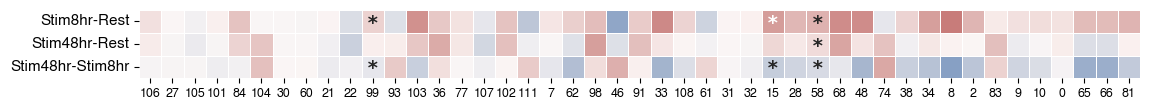

In [59]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(11.6, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T,
            vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('results/cluster_by_condition/regulator_exp_all_regulators.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Plot colormap

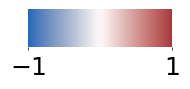

In [48]:
thres = 1
orientation = 'bottom'
colormap = 'vlag'
cmap = sns.color_palette(colormap, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-thres, thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres)+orientation+'_'+colormap+'.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Individual cluster regulator expression

In [11]:
cl = 27

regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()

# (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
regulator = [item for item in regulator if item in adata_de.var_names]

regulator_baseMean_df = pd.DataFrame(index=regulator)
regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_40446/3001937057.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=20)


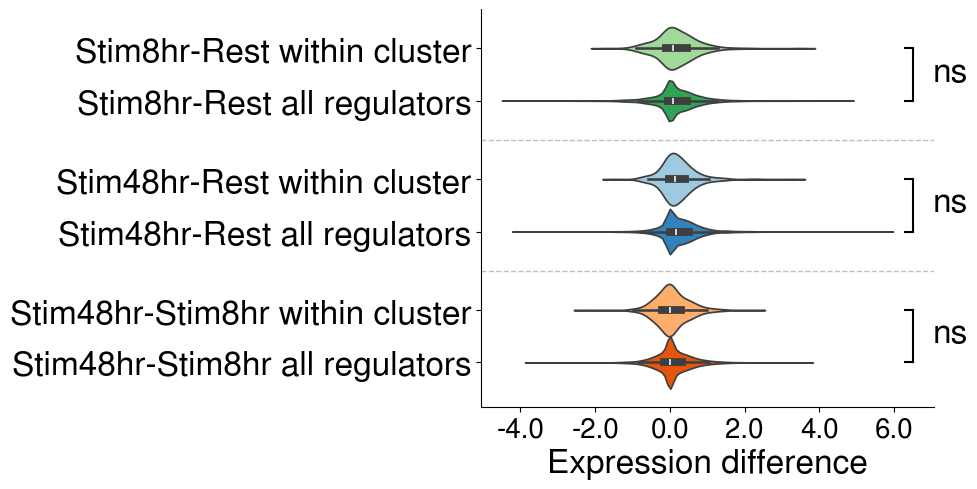

In [167]:
rest = regulator_baseMean_df['baseMean_Rest']
stim8 = regulator_baseMean_df['baseMean_Stim8hr']
stim48 = regulator_baseMean_df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest = log_stim8 - log_rest
stim48_rest = log_stim48 - log_rest
stim48_stim8 = log_stim48 - log_stim8

p_value1, p_value2, p_value3 = df_exp.loc[cl, ['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]

# Parse into DataFrame
data_frames_to_concat = [
    # Stim8hr vs Rest Comparison
    pd.DataFrame({'Value': stim8_rest, 'Comparison': 'stim8_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim8_rest_all, 'Comparison': 'stim8_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_rest, 'Comparison': 'stim48_rest', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_rest_all, 'Comparison': 'stim48_rest', 'Set': 'all regulators'}),
    pd.DataFrame({'Value': stim48_stim8, 'Comparison': 'stim48_stim8', 'Set': 'within cluster'}),
    pd.DataFrame({'Value': stim48_stim8_all, 'Comparison': 'stim48_stim8', 'Set': 'all regulators'}),
]

df = pd.concat(data_frames_to_concat, ignore_index=True)

# Plot violinplot
fig, ax = plt.subplots(figsize=(10, 5))
vp = sns.violinplot(data=df, x='Value', y='Comparison', hue='Set', ax=ax)
for i, collection in enumerate(vp.collections):
    collection.set_facecolor(colors[i])
ax.get_legend().remove()

# Plot significance
def get_sig_text(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

y_positions = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2]
x_position = 6.5
line_x_offset = 0.2
ax.plot([x_position, x_position], [y_positions[0], y_positions[1]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[0], y_positions[0]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[1], y_positions[1]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[0]+0.3, f'{get_sig_text(p_value1)}', 
        ha='center', va='bottom', fontsize=24)

ax.plot([x_position, x_position], [y_positions[2], y_positions[3]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[2], y_positions[2]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[3], y_positions[3]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[2]+0.3, f'{get_sig_text(p_value2)}', 
        ha='center', va='bottom', fontsize=24)

line_x3 = 6
ax.plot([x_position, x_position], [y_positions[4], y_positions[5]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[4], y_positions[4]], color='black', linewidth=1.5)
ax.plot([x_position - line_x_offset, x_position], [y_positions[5], y_positions[5]], color='black', linewidth=1.5)
ax.text(x_position + 1, y_positions[4]+0.3, f'{get_sig_text(p_value3)}', 
        ha='center', va='bottom', fontsize=24)


ax.set_yticks(y_positions)
ax.set_yticklabels(['Stim8hr-Rest within cluster', 'Stim8hr-Rest all regulators',
                   'Stim48hr-Rest within cluster', 'Stim48hr-Rest all regulators', 
                   'Stim48hr-Stim8hr within cluster', 'Stim48hr-Stim8hr all regulators'], fontsize=24)

ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlabel('Expression difference', fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'regulator_exp.pdf', dpi=600,
           bbox_inches='tight', pad_inches=0)

In [164]:
all_gene = []
top_perc = 0.025
for cl in adata_final.obs.hdbscan.unique():
    rank_cutoff = len(downstream_gene_df[downstream_gene_df.hdbscan_cluster==cl])*top_perc
    mask = (downstream_gene_df.hdbscan_cluster==cl)&((downstream_gene_df['zscore_rank_negative_regulation']<rank_cutoff)|(downstream_gene_df['zscore_rank_positive_regulation']<rank_cutoff))
    all_gene = all_gene + downstream_gene_df[mask].downstream_gene_ids.tolist()

all_gene = set(all_gene) \
& set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
all_gene = list(all_gene)

all_gene_baseMean_df = pd.DataFrame(index=all_gene)
all_gene_baseMean_df.loc[all_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean
all_gene_baseMean_df.loc[all_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[all_gene].baseMean

df = all_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest_all = log_stim8 - log_rest
stim48_rest_all = log_stim48 - log_rest
stim48_stim8_all = log_stim48 - log_stim8

In [273]:
len(regulator), len(set(regulator))

(129, 127)

In [315]:
df_exp = pd.DataFrame(index=downstream_gene_df['hdbscan_cluster'].unique().tolist())
for cl in downstream_gene_df['hdbscan_cluster'].unique():
    # For each cluster, choose the top 10% down-regulated genes and 10% up-regulated genes for analysis
    rank_cutoff = len(downstream_gene_df[downstream_gene_df['hdbscan_cluster']==cl])*top_perc
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=rank_cutoff) | (downstream_gene_df['zscore_rank_positive_regulation']<=rank_cutoff))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    downstream_gene_baseMean_df = pd.DataFrame(index=downstream_gene)
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
    downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean

    df = downstream_gene_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)
    
    df_exp.loc[cl, 'downstream_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'downstream_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'downstream_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'downstream_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'downstream_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'downstream_stim48_stim8_p'] = p_value3
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]

    regulator_baseMean_df = pd.DataFrame(index=regulator)
    regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
    regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

    df = regulator_baseMean_df.copy()

    rest = df['baseMean_Rest']
    stim8 = df['baseMean_Stim8hr']
    stim48 = df['baseMean_Stim48hr']
    
    log_rest = np.log1p(rest)
    log_stim8 = np.log1p(stim8)
    log_stim48 = np.log1p(stim48)
    
    stim8_rest = log_stim8 - log_rest
    stim48_rest = log_stim48 - log_rest
    stim48_stim8 = log_stim48 - log_stim8
    
    t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
    t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
    t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

    df_exp.loc[cl, 'regulator_stim8_rest_diff'] = np.mean(stim8_rest) - np.mean(stim8_rest_all)
    df_exp.loc[cl, 'regulator_stim48_rest_diff'] = np.mean(stim48_rest) - np.mean(stim48_rest_all)
    df_exp.loc[cl, 'regulator_stim48_stim8_diff'] = np.mean(stim48_stim8) - np.mean(stim48_stim8_all)
    df_exp.loc[cl, 'regulator_stim8_rest_p'] = p_value1
    df_exp.loc[cl, 'regulator_stim48_rest_p'] = p_value2
    df_exp.loc[cl, 'regulator_stim48_stim8_p'] = p_value3

In [316]:
df_exp[['downstream_stim8_rest_p','downstream_stim48_rest_p','downstream_stim48_stim8_p',
        'regulator_stim8_rest_p','regulator_stim48_rest_p','regulator_stim48_stim8_p']] = df_exp[['downstream_stim8_rest_p','downstream_stim48_rest_p','downstream_stim48_stim8_p',
        'regulator_stim8_rest_p','regulator_stim48_rest_p','regulator_stim48_stim8_p']].fillna(1)

In [317]:
df_exp['downstream_stim8_rest_fdr'] = multipletests(df_exp['downstream_stim8_rest_p'])[1]
df_exp['downstream_stim48_rest_fdr'] = multipletests(df_exp['downstream_stim48_rest_p'])[1]
df_exp['downstream_stim48_stim8_fdr'] = multipletests(df_exp['downstream_stim48_stim8_p'])[1]
df_exp['regulator_stim8_rest_fdr'] = multipletests(df_exp['regulator_stim8_rest_p'])[1]
df_exp['regulator_stim48_rest_fdr'] = multipletests(df_exp['regulator_stim48_rest_p'])[1]
df_exp['regulator_stim48_stim8_fdr'] = multipletests(df_exp['regulator_stim48_stim8_p'])[1]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [286]:
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
adata_de_obs = adata_de.obs.copy()
cluster_df.columns = ['cluster_gene_size']
cluster_df['corr_rest'] = 0
cluster_df['corr_stim8hr'] = 0
cluster_df['corr_stim48hr'] = 0

for cl in cluster_df.index.unique():
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de_obs[adata_de_obs['target_contrast_corrected'].isin(gene_id_list)].index
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()
    corr_df = corr_df.reset_index()
    corr_df = corr_df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
    cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
    cluster_df.loc[cl, 'corr_stim48hr'] = np.mean(corr_stim48hr)

cluster_df['corr_max'] = cluster_df.iloc[:,1:].max(1)
cluster_df['corr_std'] = cluster_df.iloc[:,1:].std(1)

mask = ((cluster_df.cluster_gene_size>=55)&(cluster_df.corr_max>0.2))|\
((cluster_df.cluster_gene_size<55)&(cluster_df.cluster_gene_size>6)&(cluster_df.corr_max>0.3))|\
((cluster_df.cluster_gene_size==4)&(cluster_df.corr_max>0.375))|\
((cluster_df.cluster_gene_size==6)&(cluster_df.corr_max>0.32))
condition_specificity = cluster_df[mask].copy()
condition_specificity = condition_specificity.sort_index()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03171675341206319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.026276039328289806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2898301649.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03128375786860269' has dtype inc

In [287]:
cluster_order = [81, 66, 65, 0, 9, 10, 83, 2, 8, 34, 
                 38, 74, 48, 68, 
                 15, 28, 58, 31, 32,
                 61, 108, 33, 91, 46,
                 98,
                 62, 7,
                 111, 102, 107, 77, 36, 103,
                 93, 99, 22, 21,
                 60, 30, 104, 84, 101, 105, 27, 106,
                ]

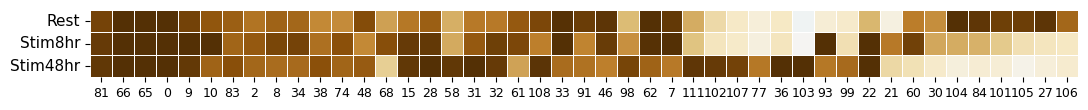

In [322]:
thres = 0.4
fig, ax = plt.subplots(figsize=(11, 1.2))
sns.heatmap(condition_specificity.loc[cluster_order, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, 
            yticklabels=['Rest', 'Stim8hr', 'Stim48hr'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()

In [312]:
df_exp

downstream_stim8_rest_diff  downstream_stim48_rest_diff  \
21                   -0.120268                    -0.139536   
35                   -0.031942                     0.000930   
33                    0.001976                     0.154467   
58                    0.079021                     0.147389   
41                    0.268213                     0.273070   
..                         ...                          ...   
72                   -0.343682                    -0.062437   
65                   -0.222085                     0.179545   
83                   -0.595519                    -0.258459   
70                   -0.055275                    -0.035012   
23                    0.256882                     0.216134   

    downstream_stim48_stim8_diff  downstream_stim8_rest_p  \
21                     -0.019268             5.107291e-02   
35                      0.032872             4.791247e-01   
33                      0.152491             9.730136e-01   
58                      0.068368             6.842777e-02   
41                      0.004857             3.738656e-10   
..                           ...                      ...   
72                      0.281244             4.369171e-02   
65                      0.401630             8.107688e-03   
83                      0.337060             6.163443e-09   
70                      0.020263             5.731208e-01   
23                     -0.040748             4.028853e-03   

    downstream_stim48_rest_p  downstream_stim48_stim8_p  \
21              1.298016e-03               5.796201e-01   
35              9.818954e-01               3.211419e-01   
33              9.129116e-03               4.580102e-03   
58              2.862212e-05               6.634318e-02   
41              2.365429e-12               8.794925e-01   
..                       ...                        ...   
72              6.362893e-01               2.503101e-02   
65              4.514327e-02               1.168716e-07   
83              8.129747e-04               2.958572e-04   
70              6.931732e-01               7.462762e-01   
23              6.265517e-03               4.278812e-01   

    regulator_stim8_rest_diff  regulator_stim48_rest_diff  \
21                  -0.023684                   -0.169055   
35                  -0.068202                   -0.019374   
33                   0.522767                    0.021880   
58                   0.315570                    0.066502   
41                   0.204749                    0.015072   
..                        ...                         ...   
72                   0.038927                    0.210699   
65                   0.263005                   -0.271449   
83                   0.042796                    0.208234   
70                  -0.078805                   -0.083161   
23                   0.106173                    0.184131   

    regulator_stim48_stim8_diff  regulator_stim8_rest_p  \
21                    -0.145371            6.424503e-01   
35                     0.048829            6.254299e-01   
33                    -0.500887            1.517804e-03   
58                    -0.249068            1.770836e-12   
41                    -0.189677            1.848250e-03   
..                          ...                     ...   
72                     0.171772            8.215015e-01   
65                    -0.534455            1.617502e-01   
83                     0.165438            1.000000e+00   
70                    -0.004356            4.897891e-01   
23                     0.077958            6.643669e-01   

    regulator_stim48_rest_p  regulator_stim48_stim8_p  \
21                 0.000038              1.841156e-04   
35                 0.838965              6.384979e-01   
33                 0.766946              1.944709e-03   
58                 0.035304              3.638647e-10   
41                 0.812678              4.158044e-03   
..                   

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/1973891733.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


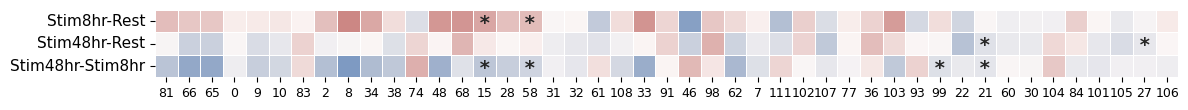

In [319]:
fail_mask = (df_exp[['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'regulator_stim8_rest_fdr': 'regulator_stim8_rest_diff',
                                      'regulator_stim48_rest_fdr': 'regulator_stim48_rest_diff',
                                      'regulator_stim48_stim8_fdr': 'regulator_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(12, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['regulator_stim8_rest_diff', 'regulator_stim48_rest_diff', 'regulator_stim48_stim8_diff']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1210/2503617819.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fail_mask_annot = (~fail_mask).applymap(convert_to_star)


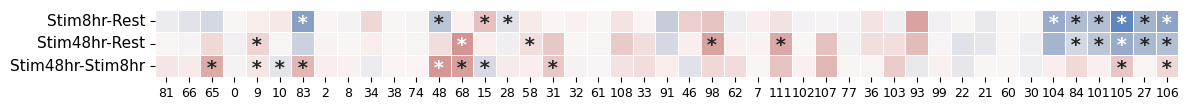

In [345]:
fail_mask = (df_exp[['downstream_stim8_rest_fdr', 'downstream_stim48_rest_fdr', 'downstream_stim48_stim8_fdr']]>0.05)
fail_mask = fail_mask.rename(columns={'downstream_stim8_rest_fdr': 'downstream_stim8_rest_diff',
                                      'downstream_stim48_rest_fdr': 'downstream_stim48_rest_diff',
                                      'downstream_stim48_stim8_fdr': 'downstream_stim48_stim8_diff'})

def convert_to_star(val):
    if val:
        return '*'
    else:
        return ''

fail_mask_annot = (~fail_mask).applymap(convert_to_star)

thres = 1
fig, ax = plt.subplots(figsize=(12, 1.2))
annot_kws = {"fontsize": 14, 'ha': 'center', 'va': 'center_baseline', 'weight': 'bold', 'fontfamily': 'monospace'}
sns.heatmap(df_exp.loc[cluster_order, ['downstream_stim8_rest_diff', 'downstream_stim48_rest_diff', 'downstream_stim48_stim8_diff']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='vlag', cbar=False, annot=fail_mask_annot.loc[cluster_order].T, fmt='', 
            yticklabels=['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], annot_kws=annot_kws)
ax.set_yticklabels(['Stim8hr-Rest', 'Stim48hr-Rest', 'Stim48hr-Stim8hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()

In [342]:
cl = 27

# For each cluster, choose the top 10% down-regulated genes and 10% up-regulated genes for analysis
rank_cutoff = len(downstream_gene_df[downstream_gene_df['hdbscan_cluster']==cl])*top_perc
mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=rank_cutoff) | (downstream_gene_df['zscore_rank_positive_regulation']<=rank_cutoff))
# Only include downstream genes that are in the summary statistics to get good estimate of baseMean
downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
downstream_gene = set(downstream_gene) \
& set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
& set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
downstream_gene = list(downstream_gene)

downstream_gene_baseMean_df = pd.DataFrame(index=downstream_gene)
downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean
downstream_gene_baseMean_df.loc[downstream_gene, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[downstream_gene].baseMean

# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].unique().tolist()

# (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
regulator = [item for item in regulator if item in adata_de.var_names]

regulator_baseMean_df = pd.DataFrame(index=regulator)
regulator_baseMean_df.loc[regulator, 'baseMean_Rest'] = de_summary_stats[de_summary_stats.condition=='Rest'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim8hr'] = de_summary_stats[de_summary_stats.condition=='Stim8hr'].set_index('target_contrast_corrected').loc[regulator].baseMean
regulator_baseMean_df.loc[regulator, 'baseMean_Stim48hr'] = de_summary_stats[de_summary_stats.condition=='Stim48hr'].set_index('target_contrast_corrected').loc[regulator].baseMean

regulator_rest = [item+'_Rest' for item in regulator]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['zscore'],
                                         index=regulator_rest,
                                         columns=downstream_gene)
regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['zscore'],
                                            index=regulator_stim8hr,
                                            columns=downstream_gene)
regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['zscore'],
                                             index=regulator_stim48hr,
                                             columns=downstream_gene)

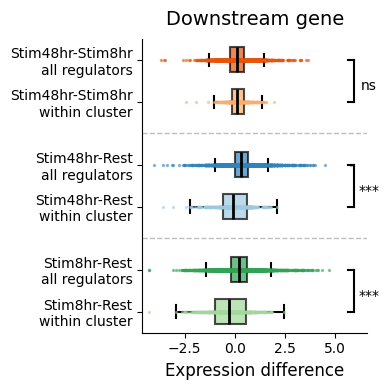

In [343]:
markersize=2

df = downstream_gene_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest = log_stim8 - log_rest
stim48_rest = log_stim48 - log_rest
stim48_stim8 = log_stim48 - log_stim8

# t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
# t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
# t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

p_value1, p_value2, p_value3 = df_exp.loc[cl, ['downstream_stim8_rest_fdr', 'downstream_stim48_rest_fdr', 'downstream_stim48_stim8_fdr']]

fig, ax = plt.subplots(figsize=(4, 4))

positions = [1, 2, 3.5, 4.5, 6, 7]
data = [stim8_rest, stim8_rest_all, stim48_rest, stim48_rest_all, stim48_stim8, stim48_stim8_all]
colors = ['#a1d99b', '#31a354', '#9ecae1', '#3182bd', '#fdae6b', '#e6550d']

bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
                showfliers=False,
                boxprops=dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, alpha=0.7),
                medianprops=dict(color='black', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5), vert=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.scatter(stim8_rest, [positions[0]]*len(stim8_rest), alpha=0.5, s=markersize, color=colors[0], zorder=2)
ax.scatter(stim8_rest_all, [positions[1]]*len(stim8_rest_all), alpha=0.5, s=markersize, color=colors[1], zorder=2)
ax.scatter(stim48_rest, [positions[2]]*len(stim48_rest), alpha=0.5, s=markersize, color=colors[2], zorder=2)
ax.scatter(stim48_rest_all, [positions[3]]*len(stim48_rest_all), alpha=0.5, s=markersize, color=colors[3], zorder=2)
ax.scatter(stim48_stim8, [positions[4]]*len(stim48_stim8), alpha=0.5, s=markersize, color=colors[4], zorder=2)
ax.scatter(stim48_stim8_all, [positions[5]]*len(stim48_stim8_all), alpha=0.5, s=markersize, color=colors[5], zorder=2)

x_max = max(stim8_rest.max(), stim8_rest_all.max(), stim48_rest.max(), stim48_rest_all.max(), stim48_stim8.max(), stim48_stim8_all.max())
x_min = min(stim8_rest.min(), stim8_rest_all.min(), stim48_rest.min(), stim48_rest_all.min(), stim48_stim8.min(), stim48_stim8_all.min())
x_range = x_max - x_min
line_x_offset = 0.03 * x_range

def get_sig_text(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

line_x1 = x_max + line_x_offset*0.5
ax.plot([line_x1, line_x1], [positions[0], positions[1]], color='black', linewidth=1.5)
ax.plot([line_x1 - line_x_offset, line_x1], [positions[0], positions[0]], color='black', linewidth=1.5)
ax.plot([line_x1 - line_x_offset, line_x1], [positions[1], positions[1]], color='black', linewidth=1.5)
ax.text(line_x1 + 0.75, positions[0]+0.2, f'{get_sig_text(p_value1)}', 
        ha='center', va='bottom', fontsize=10)

line_x2 = x_max + line_x_offset*0.5
ax.plot([line_x2, line_x2], [positions[2], positions[3]], color='black', linewidth=1.5)
ax.plot([line_x2 - line_x_offset, line_x2], [positions[2], positions[2]], color='black', linewidth=1.5)
ax.plot([line_x2 - line_x_offset, line_x2], [positions[3], positions[3]], color='black', linewidth=1.5)
ax.text(line_x2 + 0.75, positions[2]+0.2, f'{get_sig_text(p_value2)}', 
        ha='center', va='bottom', fontsize=10)

line_x3 = x_max + line_x_offset*0.5
ax.plot([line_x3, line_x3], [positions[4], positions[5]], color='black', linewidth=1.5)
ax.plot([line_x3 - line_x_offset, line_x3], [positions[4], positions[4]], color='black', linewidth=1.5)
ax.plot([line_x3 - line_x_offset, line_x3], [positions[5], positions[5]], color='black', linewidth=1.5)
ax.text(line_x3 + 0.75, positions[4]+0.2, f'{get_sig_text(p_value3)}', 
        ha='center', va='bottom', fontsize=10)

#ax.set_ylim(0, )
ax.set_yticks(positions)
ax.set_xlim(x_min-line_x_offset, line_x1+line_x_offset*2.2)
ax.set_yticklabels(['Stim8hr-Rest\nwithin cluster', 'Stim8hr-Rest\nall regulators',
                   'Stim48hr-Rest\nwithin cluster', 'Stim48hr-Rest\nall regulators', 
                   'Stim48hr-Stim8hr\nwithin cluster', 'Stim48hr-Stim8hr\nall regulators', ], fontsize=10)
ax.set_xlabel('Expression difference', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=positions[1]/2+positions[2]/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=positions[3]/2+positions[4]/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_title('Downstream gene', fontsize=14, pad=10)

plt.tight_layout()
plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'downstream_exp.pdf')

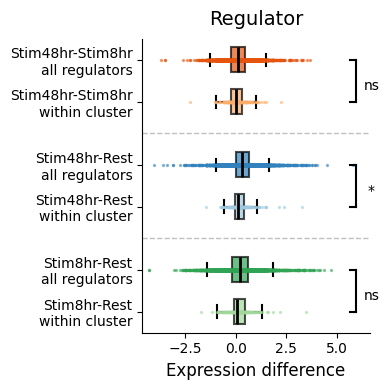

In [344]:
markersize=2

df = regulator_baseMean_df.copy()

rest = df['baseMean_Rest']
stim8 = df['baseMean_Stim8hr']
stim48 = df['baseMean_Stim48hr']

log_rest = np.log1p(rest)
log_stim8 = np.log1p(stim8)
log_stim48 = np.log1p(stim48)

stim8_rest = log_stim8 - log_rest
stim48_rest = log_stim48 - log_rest
stim48_stim8 = log_stim48 - log_stim8

# t_stat1, p_value1 = stats.ttest_ind(stim8_rest, stim8_rest_all, equal_var=False)
# t_stat2, p_value2 = stats.ttest_ind(stim48_rest, stim48_rest_all, equal_var=False)
# t_stat3, p_value3 = stats.ttest_ind(stim48_stim8, stim48_stim8_all, equal_var=False)

p_value1, p_value2, p_value3 = df_exp.loc[cl, ['regulator_stim8_rest_fdr', 'regulator_stim48_rest_fdr', 'regulator_stim48_stim8_fdr']]

fig, ax = plt.subplots(figsize=(4, 4))

positions = [1, 2, 3.5, 4.5, 6, 7]
data = [stim8_rest, stim8_rest_all, stim48_rest, stim48_rest_all, stim48_stim8, stim48_stim8_all]
colors = ['#a1d99b', '#31a354', '#9ecae1', '#3182bd', '#fdae6b', '#e6550d']

bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
                showfliers=False,
                boxprops=dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, alpha=0.7),
                medianprops=dict(color='black', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5), vert=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.scatter(stim8_rest, [positions[0]]*len(stim8_rest), alpha=0.5, s=markersize, color=colors[0], zorder=2)
ax.scatter(stim8_rest_all, [positions[1]]*len(stim8_rest_all), alpha=0.5, s=markersize, color=colors[1], zorder=2)
ax.scatter(stim48_rest, [positions[2]]*len(stim48_rest), alpha=0.5, s=markersize, color=colors[2], zorder=2)
ax.scatter(stim48_rest_all, [positions[3]]*len(stim48_rest_all), alpha=0.5, s=markersize, color=colors[3], zorder=2)
ax.scatter(stim48_stim8, [positions[4]]*len(stim48_stim8), alpha=0.5, s=markersize, color=colors[4], zorder=2)
ax.scatter(stim48_stim8_all, [positions[5]]*len(stim48_stim8_all), alpha=0.5, s=markersize, color=colors[5], zorder=2)

x_max = max(stim8_rest.max(), stim8_rest_all.max(), stim48_rest.max(), stim48_rest_all.max(), stim48_stim8.max(), stim48_stim8_all.max())
x_min = min(stim8_rest.min(), stim8_rest_all.min(), stim48_rest.min(), stim48_rest_all.min(), stim48_stim8.min(), stim48_stim8_all.min())
x_range = x_max - x_min
line_x_offset = 0.03 * x_range

def get_sig_text(p_val):
    if p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

line_x1 = x_max + line_x_offset*0.5
ax.plot([line_x1, line_x1], [positions[0], positions[1]], color='black', linewidth=1.5)
ax.plot([line_x1 - line_x_offset, line_x1], [positions[0], positions[0]], color='black', linewidth=1.5)
ax.plot([line_x1 - line_x_offset, line_x1], [positions[1], positions[1]], color='black', linewidth=1.5)
ax.text(line_x1 + 0.75, positions[0]+0.2, f'{get_sig_text(p_value1)}', 
        ha='center', va='bottom', fontsize=10)

line_x2 = x_max + line_x_offset*0.5
ax.plot([line_x2, line_x2], [positions[2], positions[3]], color='black', linewidth=1.5)
ax.plot([line_x2 - line_x_offset, line_x2], [positions[2], positions[2]], color='black', linewidth=1.5)
ax.plot([line_x2 - line_x_offset, line_x2], [positions[3], positions[3]], color='black', linewidth=1.5)
ax.text(line_x2 + 0.75, positions[2]+0.2, f'{get_sig_text(p_value2)}', 
        ha='center', va='bottom', fontsize=10)

line_x3 = x_max + line_x_offset*0.5
ax.plot([line_x3, line_x3], [positions[4], positions[5]], color='black', linewidth=1.5)
ax.plot([line_x3 - line_x_offset, line_x3], [positions[4], positions[4]], color='black', linewidth=1.5)
ax.plot([line_x3 - line_x_offset, line_x3], [positions[5], positions[5]], color='black', linewidth=1.5)
ax.text(line_x3 + 0.75, positions[4]+0.2, f'{get_sig_text(p_value3)}', 
        ha='center', va='bottom', fontsize=10)

#ax.set_ylim(0, )
ax.set_yticks(positions)
ax.set_xlim(x_min-line_x_offset, line_x1+line_x_offset*2.2)
ax.set_yticklabels(['Stim8hr-Rest\nwithin cluster', 'Stim8hr-Rest\nall regulators',
                   'Stim48hr-Rest\nwithin cluster', 'Stim48hr-Rest\nall regulators', 
                   'Stim48hr-Stim8hr\nwithin cluster', 'Stim48hr-Stim8hr\nall regulators', ], fontsize=10)
ax.set_xlabel('Expression difference', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=positions[1]/2+positions[2]/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=positions[3]/2+positions[4]/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_title('Regulator', fontsize=14, pad=10)

plt.tight_layout()
plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'regulator_exp.pdf')

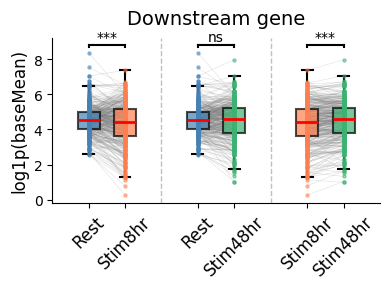

In [128]:
# df = downstream_gene_baseMean_df.copy()

# rest = df['baseMean_Rest']
# stim8 = df['baseMean_Stim8hr']
# stim48 = df['baseMean_Stim48hr']

# # log_rest = np.log(rest)
# # log_stim8 = np.log(stim8)
# # log_stim48 = np.log(stim48)

# log_rest = np.log1p(rest)
# log_stim8 = np.log1p(stim8)
# log_stim48 = np.log1p(stim48)


# # t_stat1, p_value1 = stats.ttest_rel(rest, stim8)
# # t_stat2, p_value2 = stats.ttest_rel(rest, stim48)
# # t_stat3, p_value3 = stats.ttest_rel(stim8, stim48)

# t_stat1, p_value1 = stats.ttest_rel(log_rest, log_stim8)
# t_stat2, p_value2 = stats.ttest_rel(log_rest, log_stim48)
# t_stat3, p_value3 = stats.ttest_rel(log_stim8, log_stim48)

# fig, ax = plt.subplots(figsize=(4, 3))

# positions = [1, 2, 4, 5, 7, 8]
# data = [log_rest, log_stim8, log_rest, log_stim48, log_stim8, log_stim48]
# colors = ['steelblue', 'coral', 'steelblue', 'mediumseagreen', 'coral', 'mediumseagreen']

# bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
#                 showfliers=False,
#                 boxprops=dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, alpha=0.7),
#                 medianprops=dict(color='red', linewidth=2),
#                 whiskerprops=dict(color='black', linewidth=1.5),
#                 capprops=dict(color='black', linewidth=1.5))

# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)

# for i in range(len(df)):
#     ax.plot([1, 2], [log_rest.iloc[i], log_stim8.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)
#     ax.plot([4, 5], [log_rest.iloc[i], log_stim48.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)
#     ax.plot([7, 8], [log_stim8.iloc[i], log_stim48.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)

# ax.scatter([1]*len(df), log_rest, alpha=0.5, s=5, color='steelblue', zorder=2)
# ax.scatter([2]*len(df), log_stim8, alpha=0.5, s=5, color='coral', zorder=2)
# ax.scatter([4]*len(df), log_rest, alpha=0.5, s=5, color='steelblue', zorder=2)
# ax.scatter([5]*len(df), log_stim48, alpha=0.5, s=5, color='mediumseagreen', zorder=2)
# ax.scatter([7]*len(df), log_stim8, alpha=0.5, s=5, color='coral', zorder=2)
# ax.scatter([8]*len(df), log_stim48, alpha=0.5, s=5, color='mediumseagreen', zorder=2)

# y_max = max(log_rest.max(), log_stim8.max(), log_stim48.max())
# y_min = min(log_rest.min(), log_stim8.min(), log_stim48.min())
# y_range = y_max - y_min

# def get_sig_text(p_val):
#     if p_val < 0.001:
#         return '***'
#     elif p_val < 0.01:
#         return '**'
#     elif p_val < 0.05:
#         return '*'
#     else:
#         return 'ns'

# line_y1 = y_max + 0.05 * y_range
# ax.plot([1, 2], [line_y1, line_y1], color='black', linewidth=1.5)
# ax.plot([1, 1], [line_y1 - 0.01 * y_range, line_y1], color='black', linewidth=1.5)
# ax.plot([2, 2], [line_y1 - 0.01 * y_range, line_y1], color='black', linewidth=1.5)
# ax.text(1.5, line_y1 + 0.01 * y_range, f'{get_sig_text(p_value1)}', 
#         ha='center', va='bottom', fontsize=10)

# line_y2 = y_max + 0.05 * y_range
# ax.plot([4, 5], [line_y2, line_y2], color='black', linewidth=1.5)
# ax.plot([4, 4], [line_y2 - 0.01 * y_range, line_y2], color='black', linewidth=1.5)
# ax.plot([5, 5], [line_y2 - 0.01 * y_range, line_y2], color='black', linewidth=1.5)
# ax.text(4.5, line_y2 + 0.01 * y_range, f'{get_sig_text(p_value2)}', 
#         ha='center', va='bottom', fontsize=10)

# line_y3 = y_max + 0.05 * y_range
# ax.plot([7, 8], [line_y3, line_y3], color='black', linewidth=1.5)
# ax.plot([7, 7], [line_y3 - 0.01 * y_range, line_y3], color='black', linewidth=1.5)
# ax.plot([8, 8], [line_y3 - 0.01 * y_range, line_y3], color='black', linewidth=1.5)
# ax.text(7.5, line_y3 + 0.01 * y_range, f'{get_sig_text(p_value3)}', 
#         ha='center', va='bottom', fontsize=10)

# ax.set_xlim(0, 9)
# ax.set_xticks([1, 2, 4, 5, 7, 8])
# ax.set_xticklabels(['Rest', 'Stim8hr', 'Rest', 'Stim48hr', 'Stim8hr', 'Stim48hr'], fontsize=12, rotation=45)
# ax.set_ylabel('log1p(baseMean)', fontsize=12)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
# ax.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_title('Downstream gene', fontsize=14, pad=10)

# plt.tight_layout()

# plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'downstream_exp.pdf')

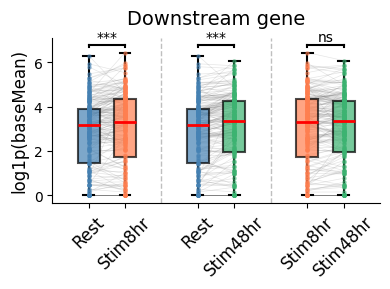

In [129]:
# df = regulator_baseMean_df.copy()

# rest = df['baseMean_Rest']
# stim8 = df['baseMean_Stim8hr']
# stim48 = df['baseMean_Stim48hr']

# # log_rest = np.log(rest)
# # log_stim8 = np.log(stim8)
# # log_stim48 = np.log(stim48)

# log_rest = np.log1p(rest)
# log_stim8 = np.log1p(stim8)
# log_stim48 = np.log1p(stim48)


# # t_stat1, p_value1 = stats.ttest_rel(rest, stim8)
# # t_stat2, p_value2 = stats.ttest_rel(rest, stim48)
# # t_stat3, p_value3 = stats.ttest_rel(stim8, stim48)

# t_stat1, p_value1 = stats.ttest_rel(log_rest, log_stim8)
# t_stat2, p_value2 = stats.ttest_rel(log_rest, log_stim48)
# t_stat3, p_value3 = stats.ttest_rel(log_stim8, log_stim48)

# fig, ax = plt.subplots(figsize=(4, 3))

# positions = [1, 2, 4, 5, 7, 8]
# data = [log_rest, log_stim8, log_rest, log_stim48, log_stim8, log_stim48]
# colors = ['steelblue', 'coral', 'steelblue', 'mediumseagreen', 'coral', 'mediumseagreen']

# bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
#                 showfliers=False,
#                 boxprops=dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, alpha=0.7),
#                 medianprops=dict(color='red', linewidth=2),
#                 whiskerprops=dict(color='black', linewidth=1.5),
#                 capprops=dict(color='black', linewidth=1.5))

# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)

# for i in range(len(df)):
#     ax.plot([1, 2], [log_rest.iloc[i], log_stim8.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)
#     ax.plot([4, 5], [log_rest.iloc[i], log_stim48.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)
#     ax.plot([7, 8], [log_stim8.iloc[i], log_stim48.iloc[i]], 
#             color='gray', alpha=0.2, linewidth=0.5, zorder=1)

# ax.scatter([1]*len(df), log_rest, alpha=0.5, s=5, color='steelblue', zorder=2)
# ax.scatter([2]*len(df), log_stim8, alpha=0.5, s=5, color='coral', zorder=2)
# ax.scatter([4]*len(df), log_rest, alpha=0.5, s=5, color='steelblue', zorder=2)
# ax.scatter([5]*len(df), log_stim48, alpha=0.5, s=5, color='mediumseagreen', zorder=2)
# ax.scatter([7]*len(df), log_stim8, alpha=0.5, s=5, color='coral', zorder=2)
# ax.scatter([8]*len(df), log_stim48, alpha=0.5, s=5, color='mediumseagreen', zorder=2)

# y_max = max(log_rest.max(), log_stim8.max(), log_stim48.max())
# y_min = min(log_rest.min(), log_stim8.min(), log_stim48.min())
# y_range = y_max - y_min

# def get_sig_text(p_val):
#     if p_val < 0.001:
#         return '***'
#     elif p_val < 0.01:
#         return '**'
#     elif p_val < 0.05:
#         return '*'
#     else:
#         return 'ns'

# line_y1 = y_max + 0.05 * y_range
# ax.plot([1, 2], [line_y1, line_y1], color='black', linewidth=1.5)
# ax.plot([1, 1], [line_y1 - 0.01 * y_range, line_y1], color='black', linewidth=1.5)
# ax.plot([2, 2], [line_y1 - 0.01 * y_range, line_y1], color='black', linewidth=1.5)
# ax.text(1.5, line_y1 + 0.01 * y_range, f'{get_sig_text(p_value1)}', 
#         ha='center', va='bottom', fontsize=10)

# line_y2 = y_max + 0.05 * y_range
# ax.plot([4, 5], [line_y2, line_y2], color='black', linewidth=1.5)
# ax.plot([4, 4], [line_y2 - 0.01 * y_range, line_y2], color='black', linewidth=1.5)
# ax.plot([5, 5], [line_y2 - 0.01 * y_range, line_y2], color='black', linewidth=1.5)
# ax.text(4.5, line_y2 + 0.01 * y_range, f'{get_sig_text(p_value2)}', 
#         ha='center', va='bottom', fontsize=10)

# line_y3 = y_max + 0.05 * y_range
# ax.plot([7, 8], [line_y3, line_y3], color='black', linewidth=1.5)
# ax.plot([7, 7], [line_y3 - 0.01 * y_range, line_y3], color='black', linewidth=1.5)
# ax.plot([8, 8], [line_y3 - 0.01 * y_range, line_y3], color='black', linewidth=1.5)
# ax.text(7.5, line_y3 + 0.01 * y_range, f'{get_sig_text(p_value3)}', 
#         ha='center', va='bottom', fontsize=10)

# ax.set_xlim(0, 9)
# ax.set_xticks([1, 2, 4, 5, 7, 8])
# ax.set_xticklabels(['Rest', 'Stim8hr', 'Rest', 'Stim48hr', 'Stim8hr', 'Stim48hr'], fontsize=12, rotation=45)
# ax.set_ylabel('log1p(baseMean)', fontsize=12)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
# ax.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_title('Downstream gene', fontsize=14, pad=10)

# plt.tight_layout()

# plt.savefig('results/cluster_by_condition/cluster'+str(cl)+'regulator_exp.pdf')

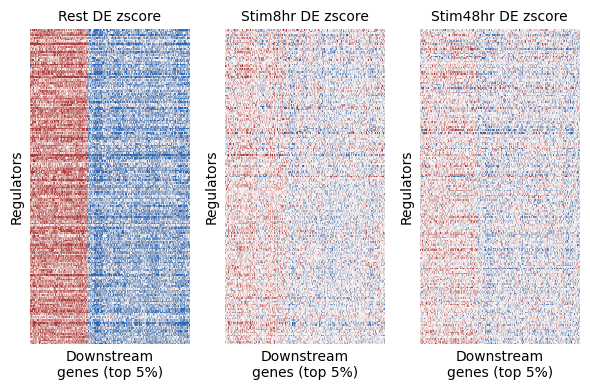

In [335]:
fontsize=10
# First curate the regulatory interaction of the main condition
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]
regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['zscore'],
                                                   index=regulator_main_condition,
                                                   columns=downstream_gene)

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(regulator_downstream_main_condition, 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
yticklabel_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)
downstream_gene = np.array(downstream_gene)[xticklabel_indices]
#regulator = np.array(regulator)[yticklabel_indices]

# Curate expression of regulator members for reordering regulators
regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                               index=regulator,
                               columns=['baseMean_Rest'])
regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                               index=regulator,
                               columns=['baseMean_Stim8hr'])
regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                               index=regulator,
                               columns=['baseMean_Stim48hr'])
regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)

clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
plt.close(clustermap.fig)
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
regulator = np.array(regulator)[xticklabel_indices]

# Curate their regulatory interactions
regulator_rest = [item+'_Rest' for item in regulator]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['zscore'],
                                         index=regulator_rest,
                                         columns=downstream_gene)
regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['zscore'],
                                            index=regulator_stim8hr,
                                            columns=downstream_gene)
regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['zscore'],
                                             index=regulator_stim48hr,
                                             columns=downstream_gene)

# Make plot
fig, ax = plt.subplots(1,3,figsize=(6,4))

# Regulator-downstream plot
vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax[0])
ax[0].set_title('Rest DE zscore', fontsize=fontsize)
ax[0].set_xlabel('Downstream\ngenes (top 5%)', fontsize=fontsize)
ax[0].set_ylabel('Regulators', fontsize=fontsize)
sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax[1])
ax[1].set_title('Stim8hr DE zscore', fontsize=fontsize)
ax[1].set_xlabel('Downstream\ngenes (top 5%)', fontsize=fontsize)
ax[1].set_ylabel('Regulators', fontsize=fontsize)
sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax[2])
ax[2].set_title('Stim48hr DE zscore', fontsize=fontsize)
ax[2].set_xlabel('Downstream\ngenes (top 5%)', fontsize=fontsize)
ax[2].set_ylabel('Regulators', fontsize=fontsize)

plt.tight_layout()

plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'_regulatory_effects.png')

In [ ]:
fontsize=20
for cl in adata_final.obs.hdbscan.unique()[0]:
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=100) | (downstream_gene_df['zscore_rank_positive_regulation']<=100))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]
    
    # First curate the regulatory interaction of the main condition
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['zscore'],
                                                       index=regulator_main_condition,
                                                       columns=downstream_gene)
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(regulator_downstream_main_condition, 
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    yticklabel_indices = clustermap.dendrogram_row.reordered_ind
    plt.close(clustermap.fig)
    downstream_gene = np.array(downstream_gene)[xticklabel_indices]
    #regulator = np.array(regulator)[yticklabel_indices]

    # Curate expression of regulator members for reordering regulators
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    plt.close(clustermap.fig)
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    regulator = np.array(regulator)[xticklabel_indices]
    
    # Curate their regulatory interactions
    regulator_rest = [item+'_Rest' for item in regulator]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
    regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['zscore'],
                                             index=regulator_rest,
                                             columns=downstream_gene)
    regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['zscore'],
                                                index=regulator_stim8hr,
                                                columns=downstream_gene)
    regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['zscore'],
                                                 index=regulator_stim48hr,
                                                 columns=downstream_gene)
    
    # Make plot
    fig, ax = plt.subplots(1,3,figsize=(10,3))

    # Regulator-downstream plot
    vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
    sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,1])
    ax[0,.set_title('Rest DE zscore', fontsize=fontsize)
    ax[0].set_xlabel('Top 5% downstream genes', fontsize=fontsize)
    ax[0].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,2])
    ax[1].set_title('Stim8hr DE zscore', fontsize=fontsize)
    ax[1].set_xlabel('Top 5% downstream genes', fontsize=fontsize)
    ax[1].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,3])
    ax[2].set_title('Stim48hr DE zscore', fontsize=fontsize)
    ax[2].set_xlabel('Top 5% downstream genes', fontsize=fontsize)
    ax[2].set_ylabel('Regulators', fontsize=fontsize)
    
    plt.suptitle('cluster '+str(cl), fontsize=36)
    plt.tight_layout()
    #plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'.png')
    #plt.close('all')

In [8]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    df = pd.DataFrame(data=data,
                      index=ind,
                      columns=adata.var_names)
    df_corr = df.T.corr()
    return df_corr

In [9]:
downstream_gene_df[downstream_gene_df['hdbscan_cluster']==40]

hdbscan_cluster  downstream_gene downstream_gene_ids  num_of_upstream  \
0                  40             DPM1     ENSG00000000419                2   
1                  40            SCYL3     ENSG00000000457                2   
2                  40         C1orf112     ENSG00000000460                5   
3                  40            FUCA2     ENSG00000001036                2   
4                  40             GCLC     ENSG00000001084                1   
...               ...              ...                 ...              ...   
8007               40        EEF1AKMT4     ENSG00000284753                2   
8008               40  ENSG00000284976     ENSG00000284976                1   
8009               40        ARHGAP11B     ENSG00000285077                4   
8010               40           PRRC2B     ENSG00000288701                2   
8011               40            HOMEZ     ENSG00000290292                2   

      sign_coherence  zscore_rank_negative_regulation  \
0                1.0                             6125   
1                1.0                             5364   
2               -1.0                             1149   
3                1.0                             6279   
4               -1.0                             3034   
...              ...                              ...   
8007             1.0                             5010   
8008            -1.0                             3075   
8009            -1.0                             1846   
8010             1.0                             5246   
8011             1.0                             4985   

      zscore_rank_positive_regulation  
0                                1888  
1                                2649  
2                                6864  
3                                1734  
4                                4979  
...                               ...  
8007                             3003  
8008                             4938  
8009                             6167  
8010                             2767  
8011                             3028  

[8012 rows x 7 columns]

In [10]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [11]:
adata_final[adata_final.obs['hdbscan']==3].obs['culture_condition'].value_counts().index[0]

'Rest'

In [12]:
de_summary_stats

target_contrast target_name condition  \
obs_names                                                        
ENSG00000012963_Stim8hr  ENSG00000012963        UBR7   Stim8hr   
ENSG00000017260_Stim8hr  ENSG00000017260      ATP2C1   Stim8hr   
ENSG00000067606_Stim8hr  ENSG00000067606       PRKCZ   Stim8hr   
ENSG00000092929_Stim8hr  ENSG00000092929      UNC13D   Stim8hr   
ENSG00000100504_Stim8hr  ENSG00000100504        PYGL   Stim8hr   
...                                  ...         ...       ...   
ENSG00000198342_Rest     ENSG00000198342      ZNF442      Rest   
ENSG00000205572_Rest     ENSG00000205572      SERF1B      Rest   
ENSG00000221890_Rest     ENSG00000221890       NPTXR      Rest   
ENSG00000236320_Rest     ENSG00000236320      SLFN14      Rest   
ENSG00000246705_Rest     ENSG00000246705       H2AFJ      Rest   

                         n_cells_target  n_up_genes  n_down_genes  \
obs_names                                                           
ENSG00000012963_Stim8hr           491.0           0             2   
ENSG00000017260_Stim8hr           469.0           0             1   
ENSG00000067606_Stim8hr           427.0           1             1   
ENSG00000092929_Stim8hr           830.0           0             2   
ENSG00000100504_Stim8hr           414.0           1             0   
...                                 ...         ...           ...   
ENSG00000198342_Rest              324.0           0             0   
ENSG00000205572_Rest               44.0           7            24   
ENSG00000221890_Rest              293.0           0             3   
ENSG00000236320_Rest              848.0           0             0   
ENSG00000246705_Rest             1173.0           2             2   

                         n_total_de_genes  ontarget_effect_size  \
obs_names                                                         
ENSG00000012963_Stim8hr                 2            -12.952742   
ENSG00000017260_Stim8hr                 1            -16.307246   
ENSG00000067606_Stim8hr                 2             -1.658755   
ENSG00000092929_Stim8hr                 2            -19.259466   
ENSG00000100504_Stim8hr                 1              0.000000   
...                                   ...                   ...   
ENSG00000198342_Rest                    0              0.000000   
ENSG00000205572_Rest                   31              0.000000   
ENSG00000221890_Rest                    3             -1.027171   
ENSG00000236320_Rest                    0              0.000000   
ENSG00000246705_Rest                    4            -18.574962   

                         ontarget_significant    baseMean  offtarget_flag  \
obs_names                                                                   
ENSG00000012963_Stim8hr                  True   43.169196            True   
ENSG00000017260_Stim8hr                  True  102.399025           False   
ENSG00000067606_Stim8hr                 False    0.965897           False   
ENSG00000092929_Stim8hr                  True   60.904483           False   
ENSG00000100504_Stim8hr                 False    0.000000           False   
...                                       ...         ...             ...   
ENSG00000198342_Rest                    False    0.000000           False   
ENSG00000205572_Rest                    False    0.000000           False   
ENSG00000221890_Rest                    False    0.798092           False   
ENSG00000236320_Rest                    False    0.000000           False   
ENSG00000246705_Rest                     True   42.729358            True   

                        n_total_genes_category ontarget_effect_category  \
obs_names                                                                 
ENSG00000012963_Stim8hr          2-10 DE genes             on-target KD   
ENSG00000017260_Stim8hr              1 DE gene             on-target KD   
ENSG00000067606_Stim8hr          2-10 DE genes          no on-target KD   
ENSG00000092929_Sti

In [13]:
fontsize=20
for cl in adata_final.obs.hdbscan.unique():
    # For each cluster, choose the top 100 down-regulated genes and 100 up-regulated genes for analysis
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=100) | (downstream_gene_df['zscore_rank_positive_regulation']<=100))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]
    
    # First curate the regulatory interaction of the main condition
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['zscore'],
                                                       index=regulator_main_condition,
                                                       columns=downstream_gene)
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(regulator_downstream_main_condition, 
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    yticklabel_indices = clustermap.dendrogram_row.reordered_ind
    plt.close(clustermap.fig)
    downstream_gene = np.array(downstream_gene)[xticklabel_indices]
    #regulator = np.array(regulator)[yticklabel_indices]

    # Curate expression of regulator members for reordering regulators
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    plt.close(clustermap.fig)
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    regulator = np.array(regulator)[xticklabel_indices]
    
    # Curate their regulatory interactions
    regulator_rest = [item+'_Rest' for item in regulator]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
    regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['zscore'],
                                             index=regulator_rest,
                                             columns=downstream_gene)
    regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['zscore'],
                                                index=regulator_stim8hr,
                                                columns=downstream_gene)
    regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['zscore'],
                                                 index=regulator_stim48hr,
                                                 columns=downstream_gene)
    
    # Curate expression of downstream genes (now reordered)
    downstream_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Rest'])
    downstream_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim8hr'])
    downstream_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim48hr'])
    downstream_exp = pd.concat([downstream_rest_exp, downstream_stim8hr_exp, downstream_stim48hr_exp], axis=1)
    
    # Curate expression of regulator members
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    # Make plot
    fig, ax = plt.subplots(2,4,figsize=(20,8))
    
    # Regulator expression
    # clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    # sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    sns.heatmap(np.log1p(regulator_exp), yticklabels=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), fontsize=fontsize)
    ax[0,0].set_ylabel('Regulators', fontsize=fontsize)
    ax[0,0].set_title('Regulator expression', fontsize=fontsize)
    
    # Downstream gene expression
    # clustermap = sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    #sns.heatmap(np.log1p(downstream_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    ax[1,0].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize=fontsize, rotation=0, ha='right')
    ax[1,0].set_title('Downstream gene expression', fontsize=fontsize)
    
    # Regulator-downstream plot
    vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
    sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,1])
    ax[0,1].set_title('Rest DE zscore', fontsize=fontsize)
    ax[0,1].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,1].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,2])
    ax[0,2].set_title('Stim8hr DE zscore', fontsize=fontsize)
    ax[0,2].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,2].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,3])
    ax[0,3].set_title('Stim48hr DE zscore', fontsize=fontsize)
    ax[0,3].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[0,3].set_ylabel('Regulators', fontsize=fontsize)
    
    # Normalized regulator-downstream plot
    sns.heatmap(regulator_downstream_rest/np.mean(np.abs(regulator_downstream_rest)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,1])
    ax[1,1].set_title('Rest normalized DE zscore', fontsize=fontsize)
    ax[1,1].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,1].set_ylabel('Regulators', fontsize=fontsize)
    sns.heatmap(regulator_downstream_stim8hr/np.mean(np.abs(regulator_downstream_stim8hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,2])
    ax[1,2].set_title('Stim8hr normalized DE zscore', fontsize=20)
    ax[1,2].set_xlabel('Top 200 downstream genes', fontsize=12)
    ax[1,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr/np.mean(np.abs(regulator_downstream_stim48hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,3])
    ax[1,3].set_title('Stim48hr normalized DE zscore', fontsize=fontsize)
    ax[1,3].set_xlabel('Top 200 downstream genes', fontsize=fontsize)
    ax[1,3].set_ylabel('Regulators', fontsize=fontsize)
    plt.suptitle('cluster '+str(cl), fontsize=36)
    plt.tight_layout()
    plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'.png')
    plt.close('all')

<Axes: >

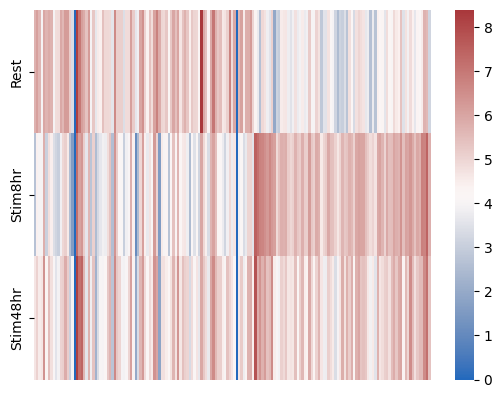

In [309]:
sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

<Axes: >

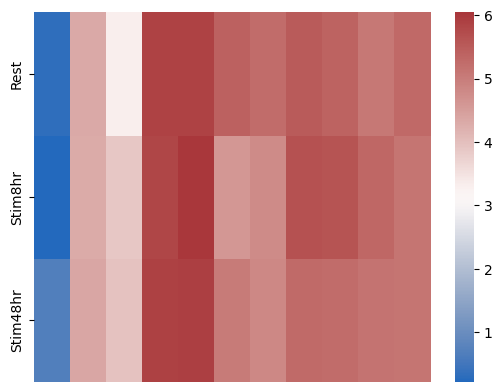

In [298]:
clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
plt.close(clustermap.fig)
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

<Axes: >

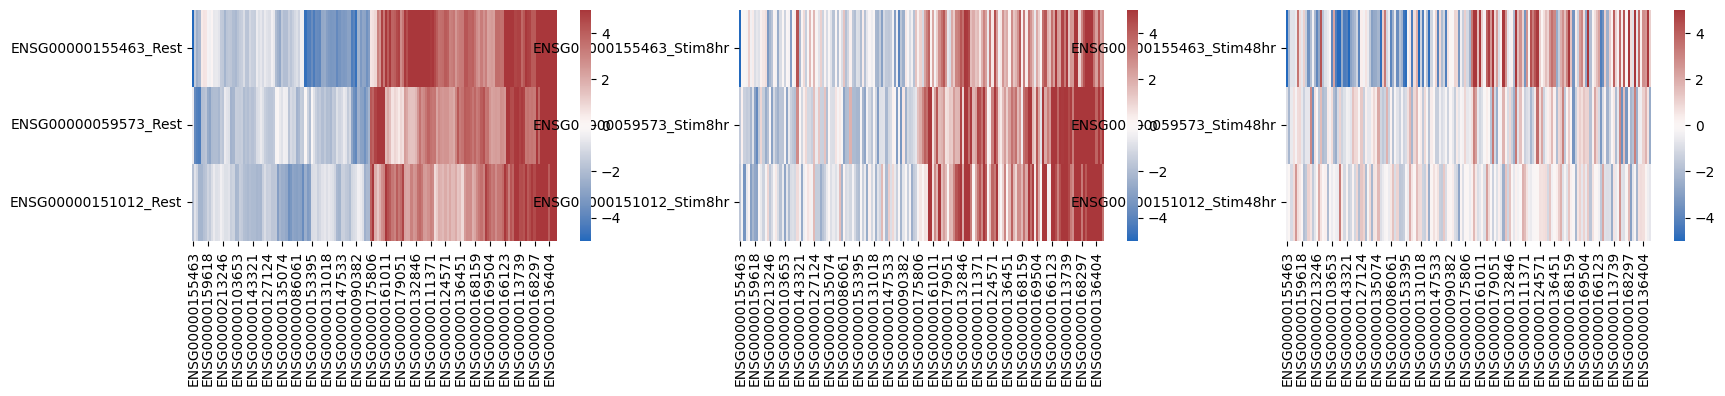

In [281]:
thres = 5
fig, ax = plt.subplots(1,3,figsize=(20,3))
sns.heatmap(regulator_downstream_rest, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[0])
sns.heatmap(regulator_downstream_stim8hr, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[1])
sns.heatmap(regulator_downstream_stim48hr, vmin=-thres, vmax=thres, cmap='vlag', ax=ax[2])

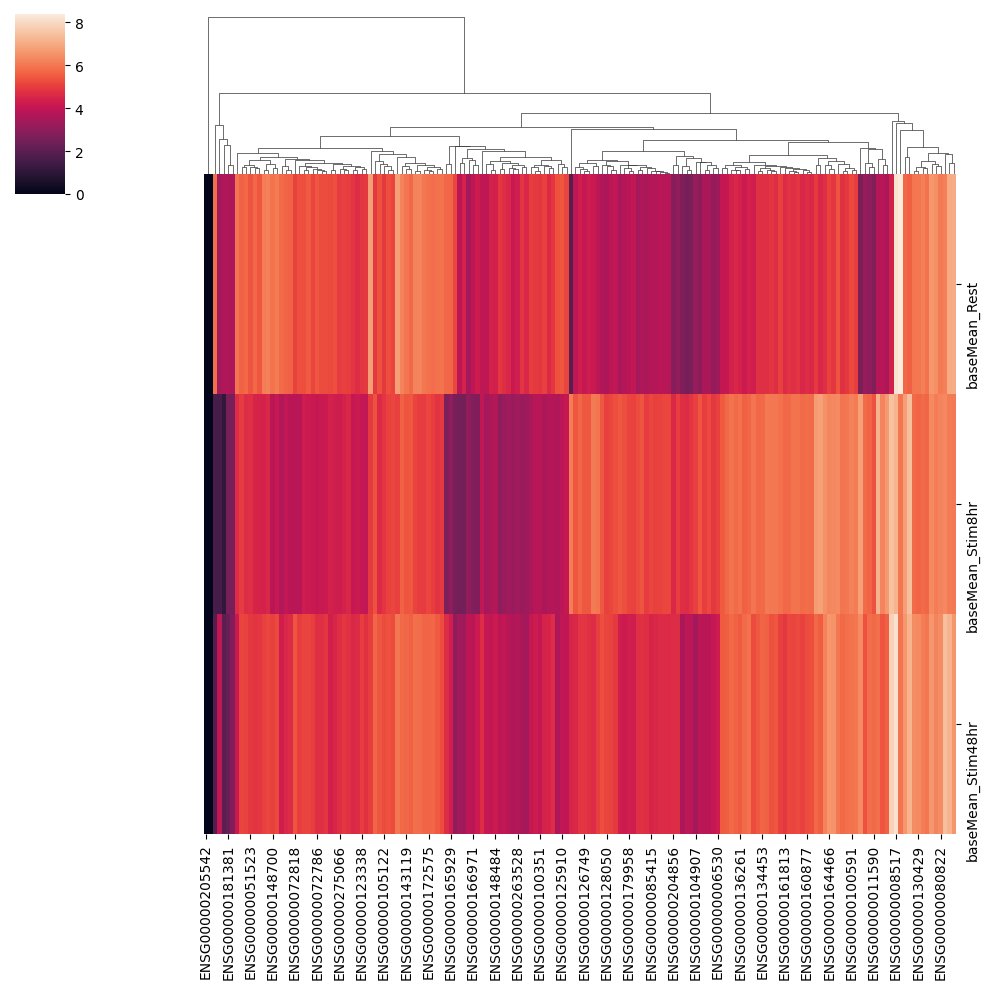

In [297]:
sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)

In [328]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [330]:
for cl in adata_final.obs.hdbscan.unique():
    # For each cluster, choose the top 100 down-regulated genes and 100 up-regulated genes for analysis
    mask = (downstream_gene_df['hdbscan_cluster']==cl) & ((downstream_gene_df['zscore_rank_negative_regulation']<=100) | (downstream_gene_df['zscore_rank_positive_regulation']<=100))
    # Only include downstream genes that are in the summary statistics to get good estimate of baseMean
    downstream_gene = downstream_gene_df[mask]['downstream_gene_ids'].tolist()
    downstream_gene = set(downstream_gene) \
    & set(de_summary_stats[de_summary_stats['condition']=='Rest']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim8hr']['target_contrast_corrected']) \
    & set(de_summary_stats[de_summary_stats['condition']=='Stim48hr']['target_contrast_corrected'])
    downstream_gene = list(downstream_gene)
    
    # For each cluster, get regulator member list
    regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_corrected'].tolist()
    
    # (Only for this analysis), only include regulators that have DE analysis included in all three conditions and are measured in gene expression matrix
    regulator = [item for item in regulator if np.sum(adata_de.obs['target_contrast_corrected']==item)==3]
    regulator = [item for item in regulator if item in adata_de.var_names]
    
    # First curate the regulatory interaction of the main condition
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    regulator_downstream_main_condition = pd.DataFrame(data=adata_de[regulator_main_condition, downstream_gene].layers['log_fc'],
                                                       index=regulator_main_condition,
                                                       columns=downstream_gene)
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(regulator_downstream_main_condition, 
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    yticklabel_indices = clustermap.dendrogram_row.reordered_ind
    plt.close(clustermap.fig)
    downstream_gene = np.array(downstream_gene)[xticklabel_indices]
    #regulator = np.array(regulator)[yticklabel_indices]

    # Curate expression of regulator members for reordering regulators
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    plt.close(clustermap.fig)
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    regulator = np.array(regulator)[xticklabel_indices]
    
    # Curate their regulatory interactions
    regulator_rest = [item+'_Rest' for item in regulator]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator]
    regulator_downstream_rest = pd.DataFrame(data=adata_de[regulator_rest, downstream_gene].layers['log_fc'],
                                             index=regulator_rest,
                                             columns=downstream_gene)
    regulator_downstream_stim8hr = pd.DataFrame(data=adata_de[regulator_stim8hr, downstream_gene].layers['log_fc'],
                                                index=regulator_stim8hr,
                                                columns=downstream_gene)
    regulator_downstream_stim48hr = pd.DataFrame(data=adata_de[regulator_stim48hr, downstream_gene].layers['log_fc'],
                                                 index=regulator_stim48hr,
                                                 columns=downstream_gene)
    
    # Curate expression of downstream genes (now reordered)
    downstream_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Rest'])
    downstream_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim8hr'])
    downstream_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[downstream_gene, 'gene_ids']], 'baseMean'].values,
                                   index=downstream_gene,
                                   columns=['baseMean_Stim48hr'])
    downstream_exp = pd.concat([downstream_rest_exp, downstream_stim8hr_exp, downstream_stim48hr_exp], axis=1)
    
    # Curate expression of regulator members
    regulator_rest_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Rest' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Rest'])
    regulator_stim8hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim8hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim8hr'])
    regulator_stim48hr_exp = pd.DataFrame(data=de_summary_stats.loc[[item+'_Stim48hr' for item in adata_de.var.loc[regulator, 'gene_ids']], 'baseMean'].values,
                                   index=regulator,
                                   columns=['baseMean_Stim48hr'])
    regulator_exp = pd.concat([regulator_rest_exp, regulator_stim8hr_exp, regulator_stim48hr_exp], axis=1)
    
    # Make plot
    fig, ax = plt.subplots(2,4,figsize=(20,6))
    
    # Regulator expression
    # clustermap = sns.clustermap(np.log1p(regulator_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    # sns.heatmap(np.log1p(regulator_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    sns.heatmap(np.log1p(regulator_exp), yticklabels=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[0,0])
    ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), fontsize=12)
    ax[0,0].set_ylabel('Regulators', fontsize=12)
    ax[0,0].set_title('Regulator expression')
    
    # Downstream gene expression
    # clustermap = sns.clustermap(np.log1p(downstream_exp.T), row_cluster=False)
    # plt.close(clustermap.fig)
    # xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    #sns.heatmap(np.log1p(downstream_exp.iloc[xticklabel_indices].T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    sns.heatmap(np.log1p(downstream_exp.T), xticklabels=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'], cmap='vlag', ax=ax[1,0])
    ax[1,0].set_xlabel('Downstream genes', fontsize=12)
    ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize=12, rotation=0, ha='right')
    ax[1,0].set_title('Downstream gene expression')
    
    # Regulator-downstream plot
    vscale = np.mean([np.mean(np.abs(regulator_downstream_rest)), np.mean(np.abs(regulator_downstream_stim8hr)), np.mean(np.abs(regulator_downstream_stim48hr))])
    sns.heatmap(regulator_downstream_rest, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,1])
    ax[0,1].set_title('Rest DE lfc')
    ax[0,1].set_xlabel('Downstream genes', fontsize=12)
    ax[0,1].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim8hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,2])
    ax[0,2].set_title('Stim8hr DE lfc')
    ax[0,2].set_xlabel('Downstream genes', fontsize=12)
    ax[0,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr, vmin=-3*vscale, vmax=3*vscale, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[0,3])
    ax[0,3].set_title('Stim48hr DE lfc')
    ax[0,3].set_xlabel('Downstream genes', fontsize=12)
    ax[0,3].set_ylabel('Regulators', fontsize=12)
    
    # Normalized regulator-downstream plot
    sns.heatmap(regulator_downstream_rest/np.mean(np.abs(regulator_downstream_rest)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,1])
    ax[1,1].set_title('Rest normalized DE lfc')
    ax[1,1].set_xlabel('Downstream genes', fontsize=12)
    ax[1,1].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim8hr/np.mean(np.abs(regulator_downstream_stim8hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,2])
    ax[1,2].set_title('Stim8hr normalized DE lfc')
    ax[1,2].set_xlabel('Downstream genes', fontsize=12)
    ax[1,2].set_ylabel('Regulators', fontsize=12)
    sns.heatmap(regulator_downstream_stim48hr/np.mean(np.abs(regulator_downstream_stim48hr)), vmin=-3, vmax=3, xticklabels=False, yticklabels=False, cmap='vlag', ax=ax[1,3])
    ax[1,3].set_title('Stim48hr normalized DE lfc')
    ax[1,3].set_xlabel('Downstream genes', fontsize=12)
    ax[1,3].set_ylabel('Regulators', fontsize=12)
    plt.suptitle('cluster '+str(cl), fontsize=24)
    plt.tight_layout()
    plt.savefig('./results/cluster_by_condition/cluster'+str(cl)+'_lfc.png')
    plt.close('all')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` 

In [31]:
adata_de[regulator_rest, downstream_gene].layers['zscore'].shape

(11, 200)

In [23]:
adata_final.obs

target_contrast_gene_name culture_condition  \
ENSG00000104368_Stim8hr                       PLAT           Stim8hr   
ENSG00000128607_Stim8hr                    KLHDC10           Stim8hr   
ENSG00000163600_Stim8hr                       ICOS           Stim8hr   
ENSG00000174177_Stim8hr                       CTU2           Stim8hr   
ENSG00000108064_Stim48hr                      TFAM          Stim48hr   
...                                            ...               ...   
ENSG00000127152_Stim48hr                    BCL11B          Stim48hr   
ENSG00000134323_Rest                          MYCN              Rest   
ENSG00000137265_Rest                          MUM1              Rest   
ENSG00000157426_Rest                         AASDH              Rest   
ENSG00000162604_Rest                         TM2D1              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000104368_Stim8hr   ENSG00000104368     0           411.0   
ENSG00000128607_Stim8hr   ENSG00000128607     0          1257.0   
ENSG00000163600_Stim8hr   ENSG00000163600     0           658.0   
ENSG00000174177_Stim8hr   ENSG00000174177     0           500.0   
ENSG00000108064_Stim48hr  ENSG00000108064     1           414.0   
...                                   ...   ...             ...   
ENSG00000127152_Stim48hr  ENSG00000127152   679           203.0   
ENSG00000134323_Rest      ENSG00000134323   680           924.0   
ENSG00000137265_Rest      ENSG00000137265   680           803.0   
ENSG00000157426_Rest      ENSG00000157426   680           651.0   
ENSG00000162604_Rest      ENSG00000162604   680           717.0   

                         target_contrast_corrected  \
ENSG00000104368_Stim8hr            ENSG00000104368   
ENSG00000128607_Stim8hr            ENSG00000128607   
ENSG00000163600_Stim8hr            ENSG00000163600   
ENSG00000174177_Stim8hr            ENSG00000174177   
ENSG00000108064_Stim48hr           ENSG00000108064   
...                                            ...   
ENSG00000127152_Stim48hr           ENSG00000127152   
ENSG00000134323_Rest               ENSG00000134323   
ENSG00000137265_Rest               ENSG00000137265   
ENSG00000157426_Rest               ENSG00000157426   
ENSG00000162604_Rest               ENSG00000162604   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000104368_Stim8hr                                 PLAT      36  
ENSG00000128607_Stim8hr                              KLHDC10      66  
ENSG00000163600_Stim8hr                                 ICOS      66  
ENSG00000174177_Stim8hr                                 CTU2      20  
ENSG00000108064_Stim48hr                                TFAM      71  
...                                                      ...     ...  
ENSG00000127152_Stim48hr                              BCL11B     101  
ENSG00000134323_Rest                                    MYCN      21  
ENSG00000137265_Rest                                    IRF4      90  
ENSG00000157426_Rest                                   AASDH      91  
ENSG00000162604_Rest                                   TM2D1      63  

[1959 rows x 8 columns]

In [8]:
adata_final

AnnData object with n_obs × n_vars = 1959 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [10]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

In [11]:
adata_final.obs.hdbscan.unique()

[36, 66, 20, 71, 96, ..., 59, 85, 83, 67, 78]
Length: 55
Categories (55, int64): [0, 2, 3, 4, ..., 96, 97, 98, 101]

### First identify condition-specific clusters

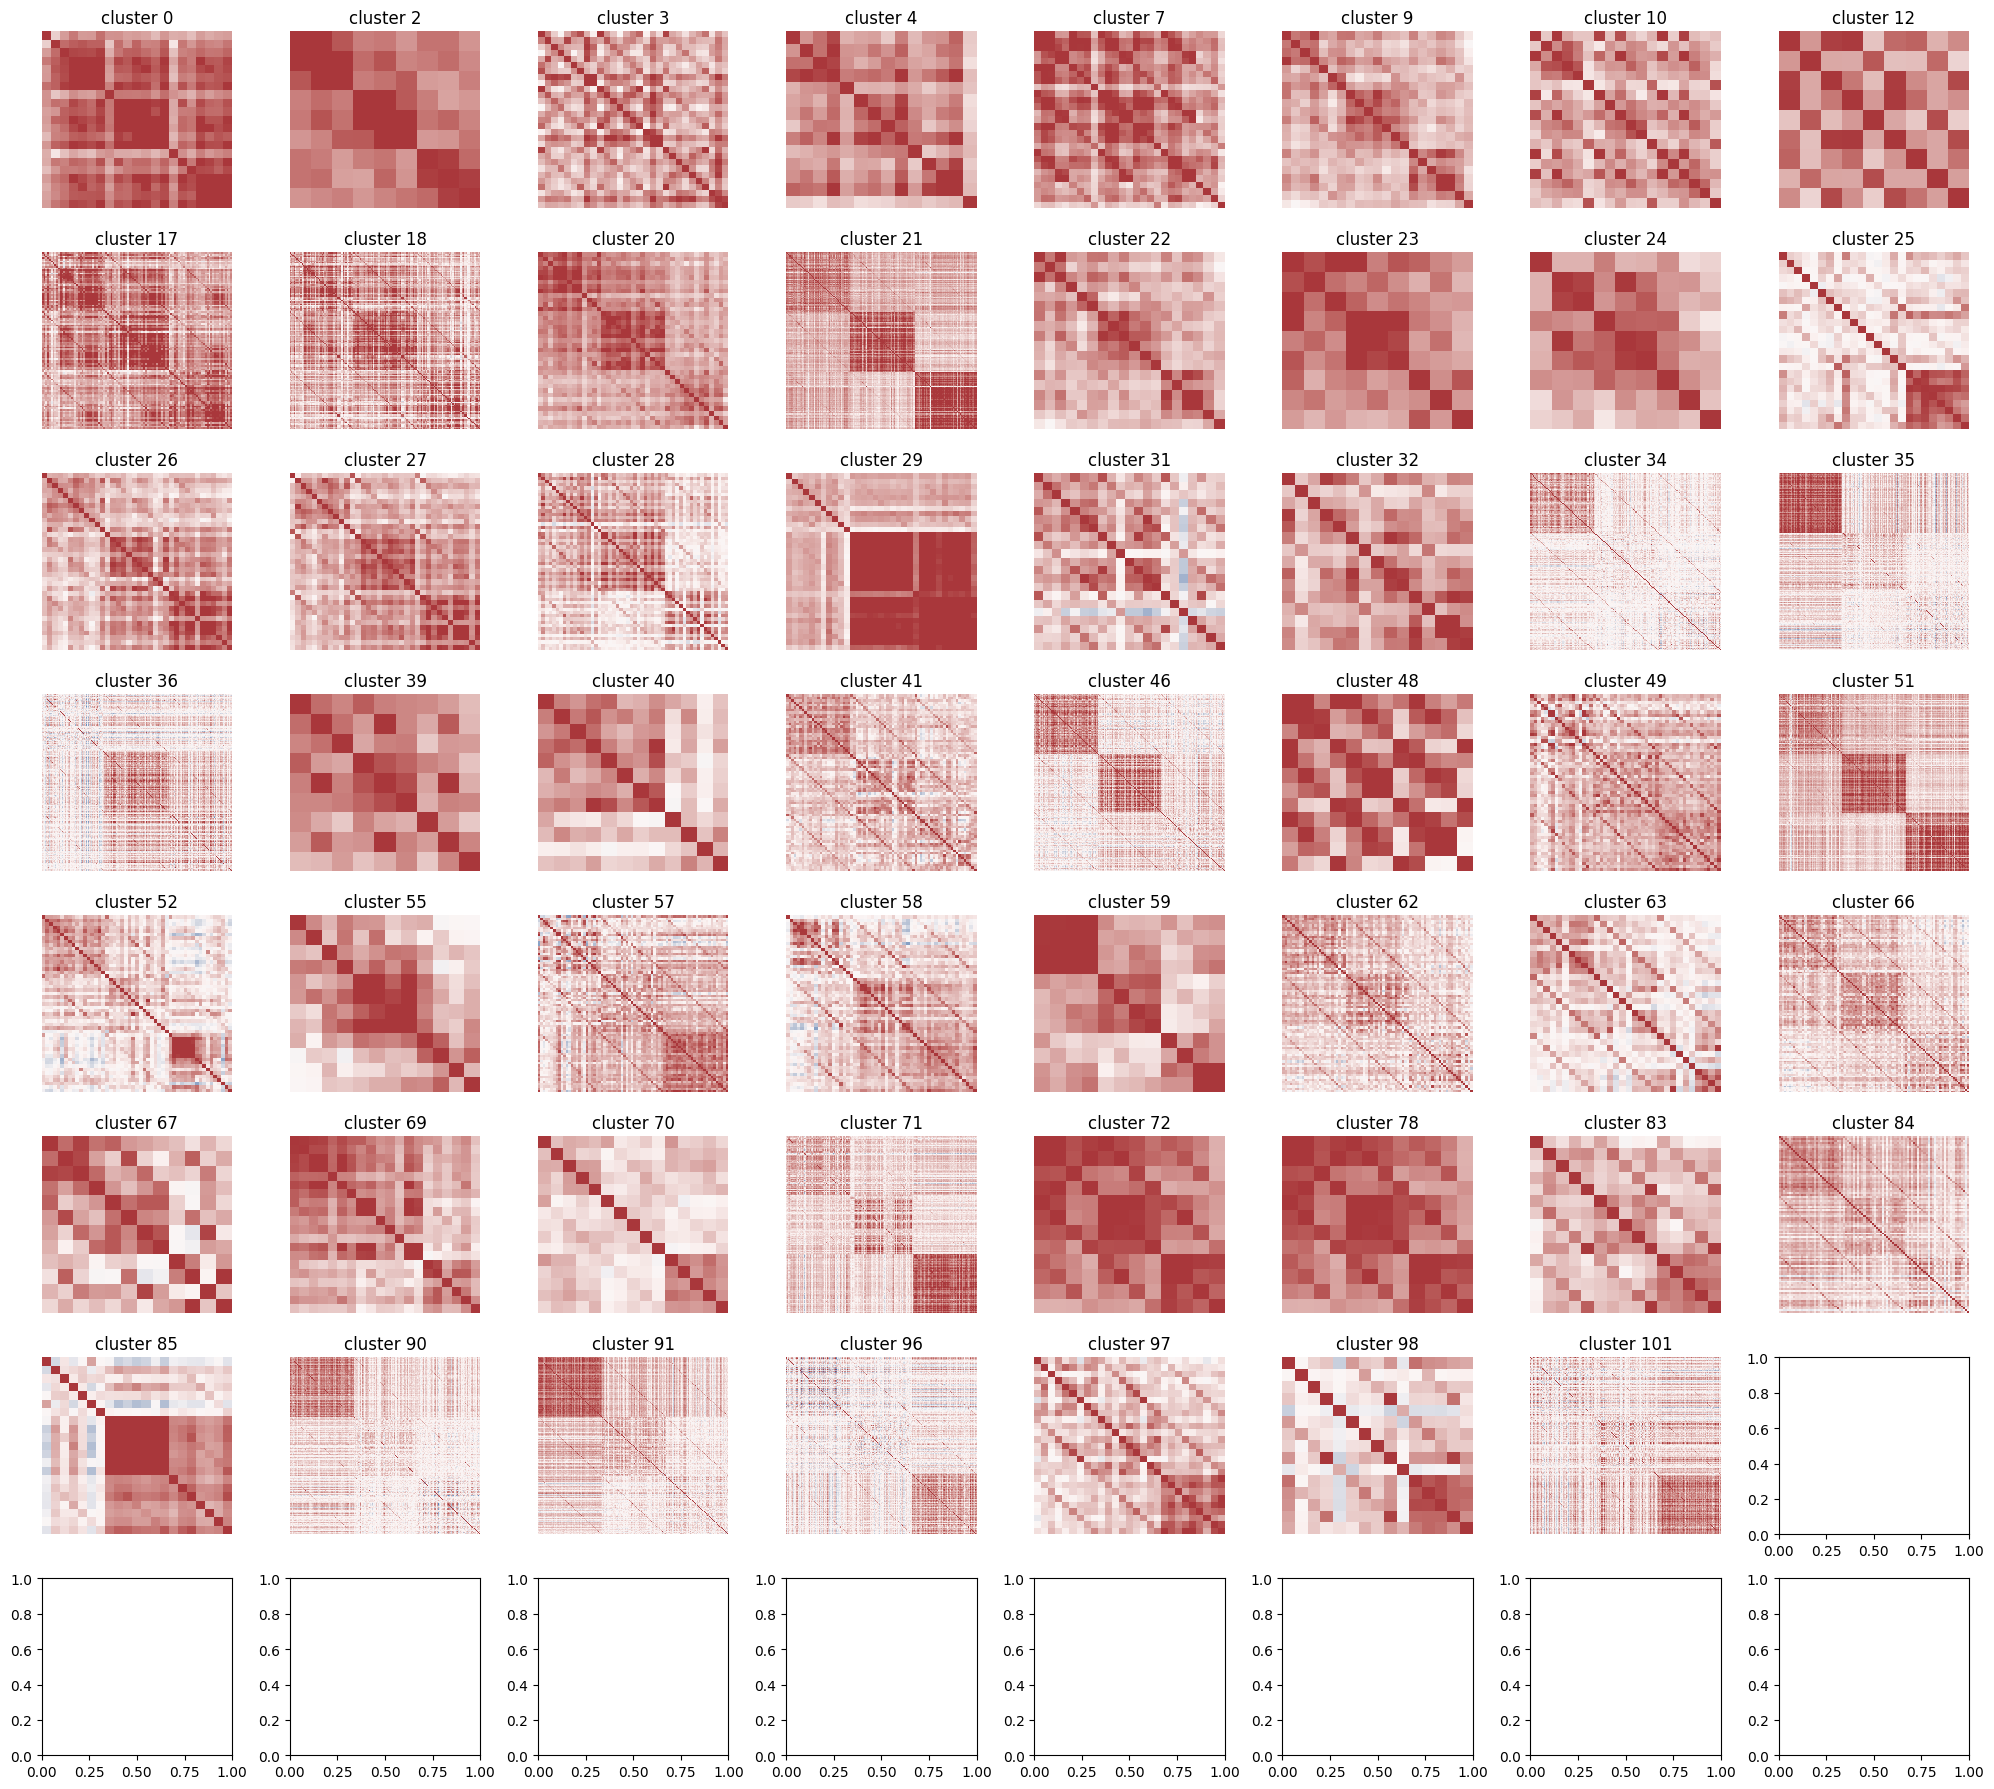

In [12]:
fig, axes = plt.subplots(8,8,figsize=(20,18))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(55):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [134]:
stim48hr_specific_cluster = [25, 57, 70, 97, 98, 101]
rest_specific_cluster = [34, 35, 90, 91]
stim8hr_specific_cluster = [36, 55, 85]
rest_stim8hr_cluster = [20, 40, 41, 46, 62, 66]
stim8hr_stim48hr_cluster = [29]

### First check gene expression

In [242]:
df_mean_std = pd.DataFrame({'condition': ['Rest', 'Rest', 'Stim8hr', 'Stim8hr', 'Stim48hr', 'Stim48hr'],
                            'mean_or_std': ['mean', 'std', 'mean', 'std', 'mean', 'std'],
                            'values': [de_summary_stats[de_summary_stats.condition=='Rest'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Rest'].baseMean.std(),
                                       de_summary_stats[de_summary_stats.condition=='Stim8hr'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Stim8hr'].baseMean.std(),
                                       de_summary_stats[de_summary_stats.condition=='Stim48hr'].baseMean.mean(),
                                       de_summary_stats[de_summary_stats.condition=='Stim48hr'].baseMean.std()]})

def calculate_expression_zscore(row, df_mean_std):
    """
    Calculate zscore of gene expression from mean expression of matching condition
    """
    mean = df_mean_std[(df_mean_std['condition']==row['condition'])&(df_mean_std['mean_or_std']=='mean')]['values'].values[0]
    std = df_mean_std[(df_mean_std['condition']==row['condition'])&(df_mean_std['mean_or_std']=='std')]['values'].values[0]
    
    return (row['baseMean'] - mean)/std

In [243]:
de_summary_stats['baseMean_zscore'] = de_summary_stats.apply(calculate_expression_zscore, axis=1, df_mean_std=df_mean_std)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/499373335.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


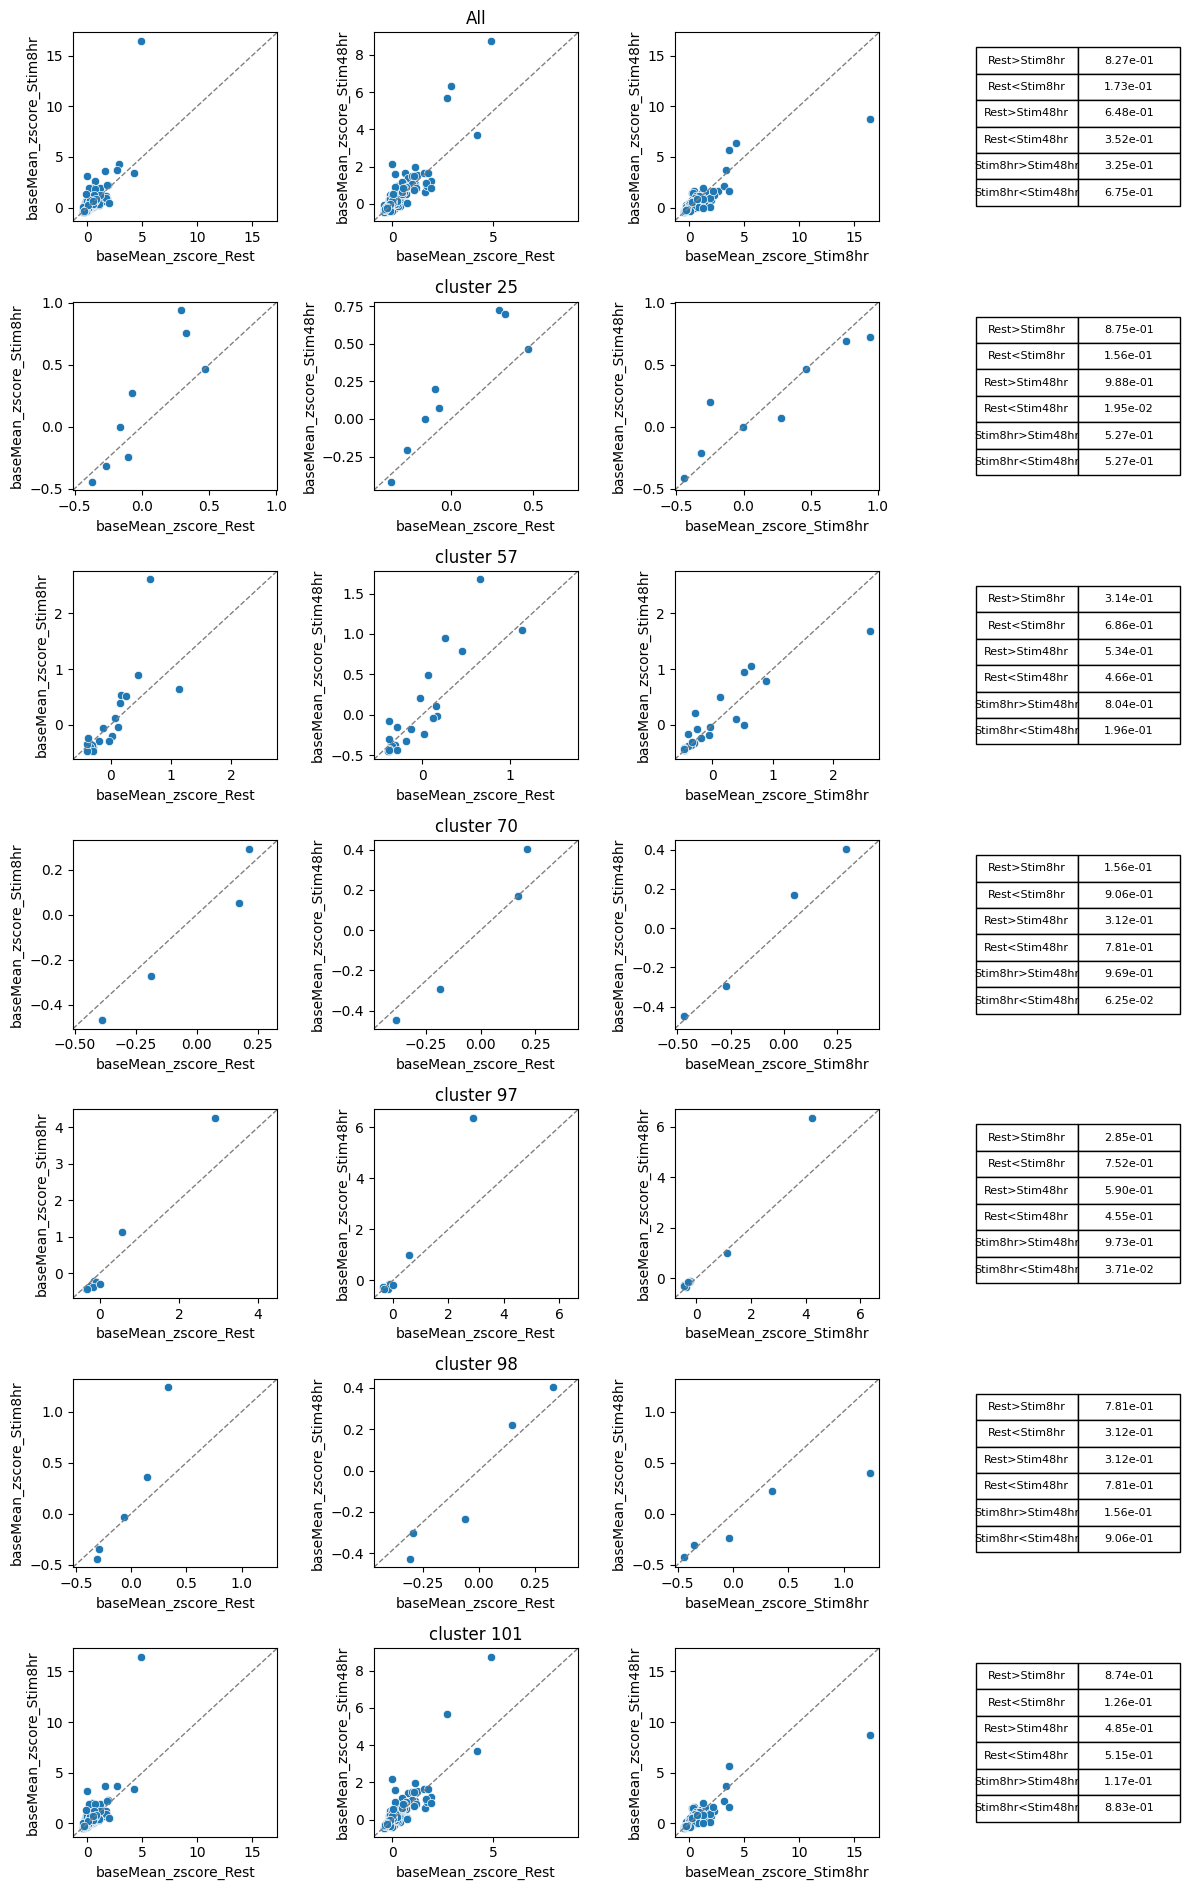

In [273]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim48hr_specific_cluster)+1,4,figsize=(12,3*len(stim48hr_specific_cluster)+1))
for i, cluster in enumerate(stim48hr_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim48hr_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/3760824205.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


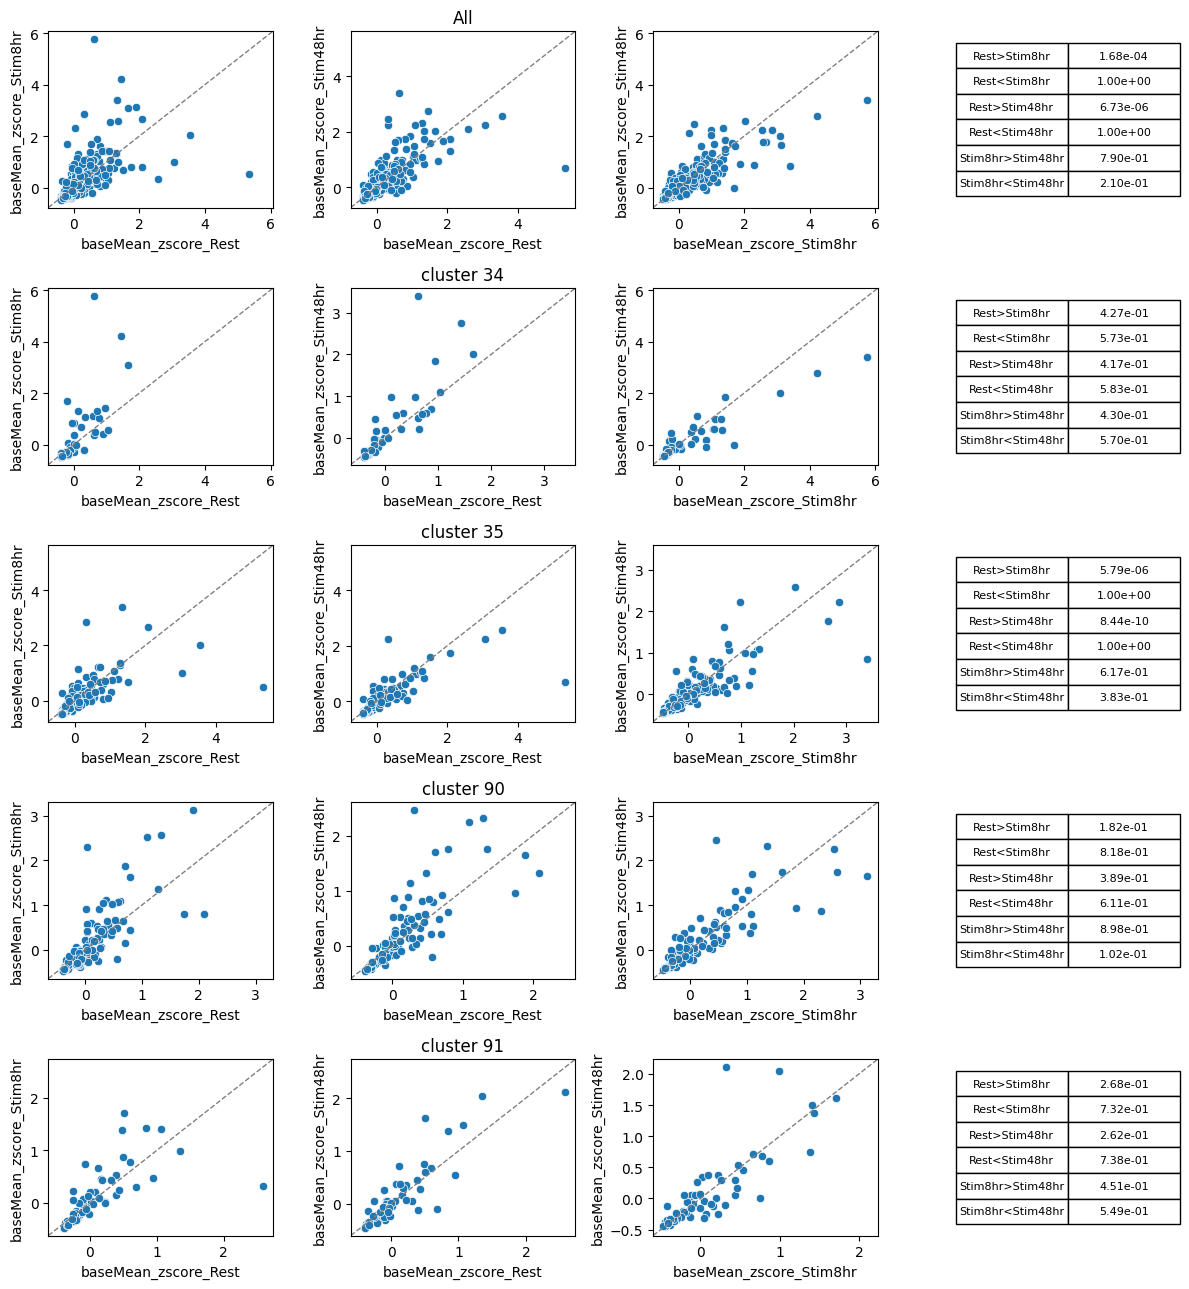

In [274]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(rest_specific_cluster)+1,4,figsize=(12,3*len(rest_specific_cluster)+1))
for i, cluster in enumerate(rest_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/rest_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/3975744631.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


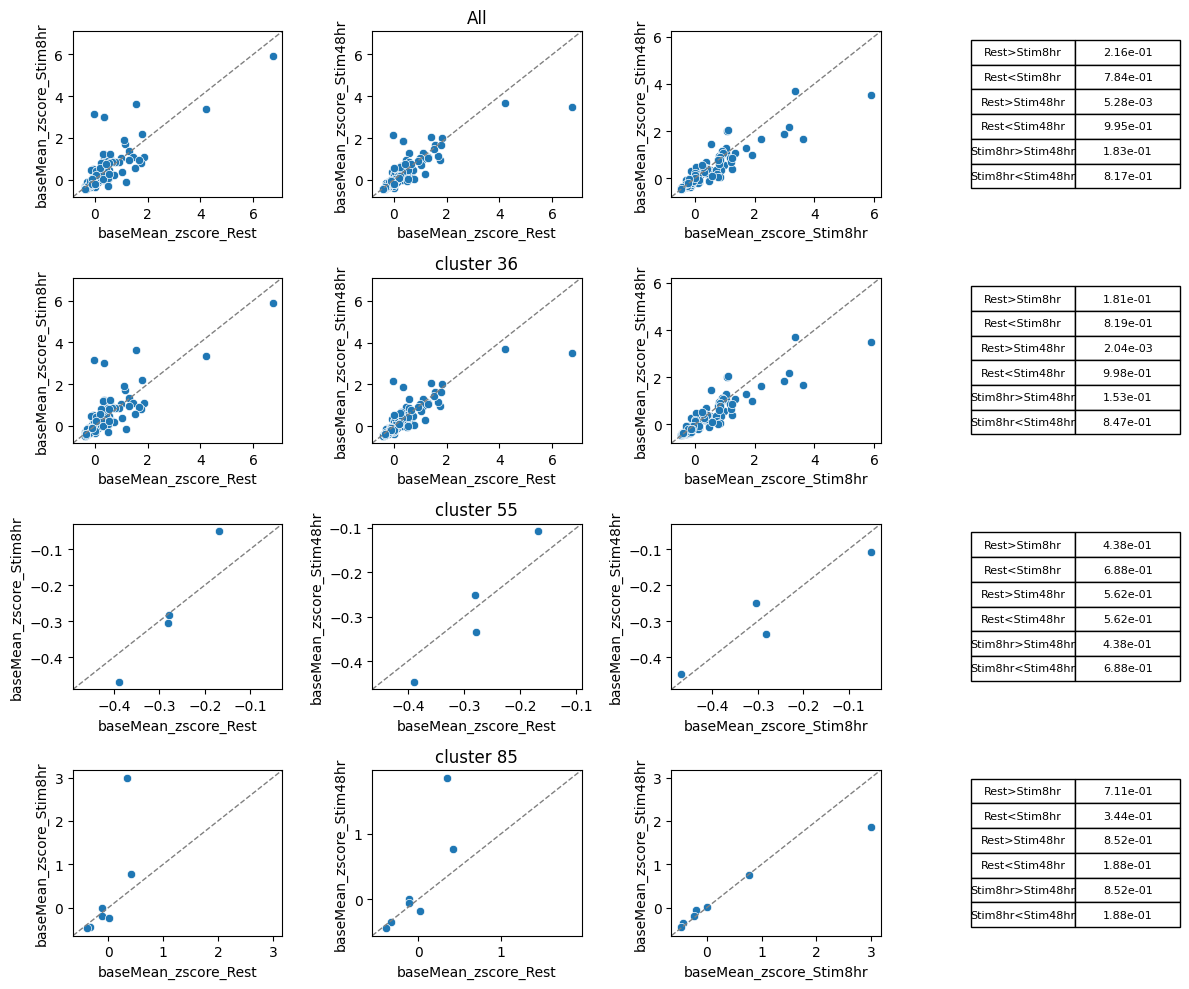

In [275]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim8hr_specific_cluster)+1,4,figsize=(12,3*len(stim8hr_specific_cluster)+1))
for i, cluster in enumerate(stim8hr_specific_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim8hr_specific_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/4257736183.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


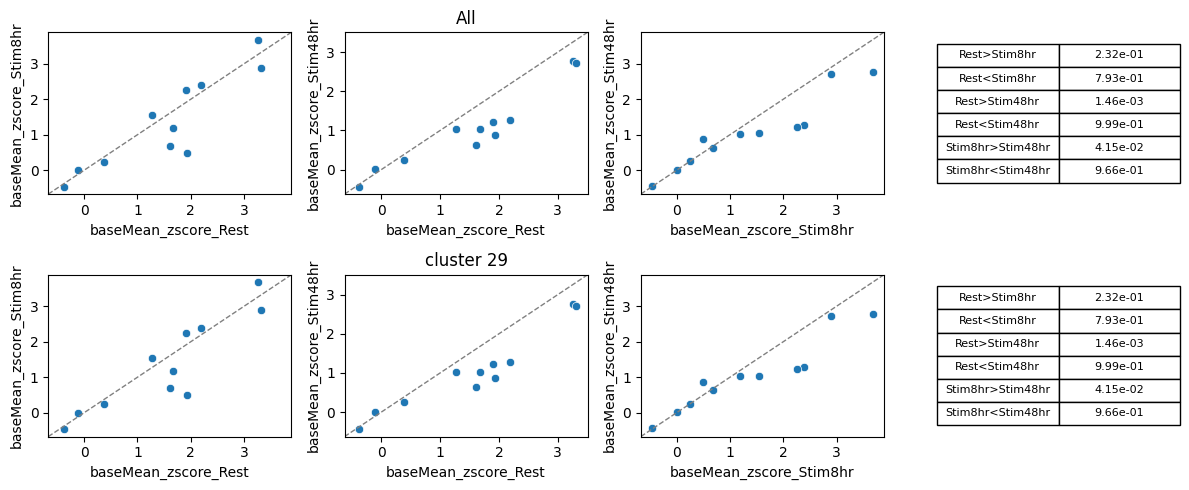

In [277]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(stim8hr_stim48hr_cluster)+1,4,figsize=(12,4*len(stim8hr_stim48hr_cluster)+1))
for i, cluster in enumerate(stim8hr_stim48hr_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/stim8hr_stim48hr_cluster_baseMean_zscore_comparison.png')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_2020/1438141475.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df])


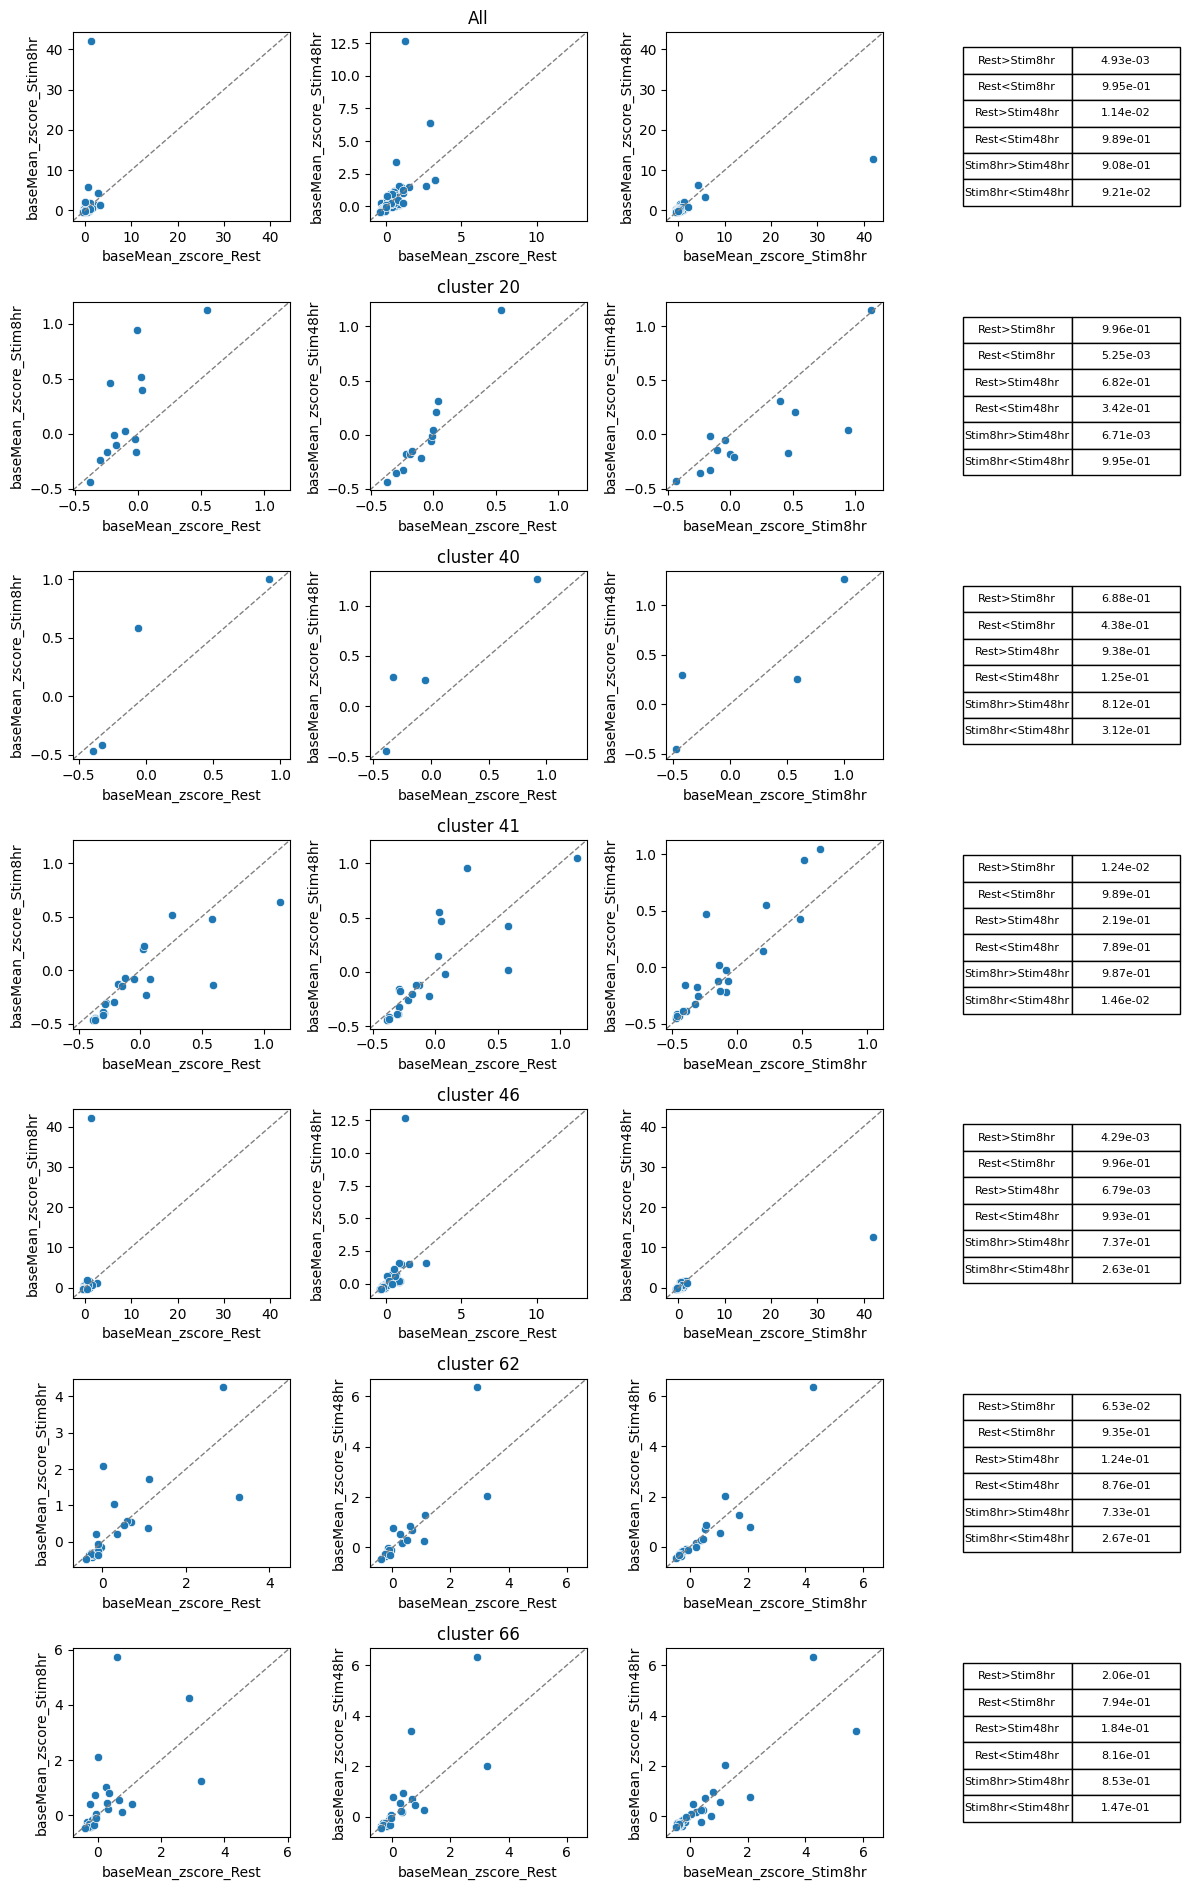

In [279]:
df_all = pd.DataFrame(columns=['baseMean_zscore_Rest','baseMean_zscore_Stim8hr','baseMean_zscore_Stim48hr'])
fig, ax = plt.subplots(len(rest_stim8hr_cluster)+1,4,figsize=(12,3*len(rest_stim8hr_cluster)+1))
for i, cluster in enumerate(rest_stim8hr_cluster):
    genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

    # Get zscore dataframe
    df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected')
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True, suffixes=('_Rest', '_Stim8hr'))
    df = pd.merge(df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean_zscore', 'target_name_corrected']].set_index('target_name_corrected'),
                  left_index=True, right_index=True)
    df = df.rename(columns={'baseMean_zscore': 'baseMean_zscore_Stim48hr'})
    
    comparison = []
    pvalues = []
    condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
    for j, pair in enumerate(condition_pair):
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
        comparison.append(pair[0]+'>'+pair[1])
        pvalues.append(stats.wilcoxon(df['baseMean_zscore_'+pair[0]], df['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
        comparison.append(pair[0]+'<'+pair[1])
        sns.scatterplot(df, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[i+1,j])
        min_val = min(df['baseMean_zscore_'+pair[0]].min(), df['baseMean_zscore_'+pair[1]].min())
        max_val = max(df['baseMean_zscore_'+pair[0]].max(), df['baseMean_zscore_'+pair[1]].max())
        buffer = (max_val - min_val) * 0.05
        min_limit = min_val - buffer
        max_limit = max_val + buffer
        ax[i+1,j].set_xlim(min_limit, max_limit)
        ax[i+1,j].set_ylim(min_limit, max_limit)
        ax[i+1,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
    
    df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
    df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
    table = ax[i+1,3].table(df_comparison.values, cellLoc='center', loc='center')
    ax[i+1,3].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    df_all = pd.concat([df_all, df])
    ax[i+1,1].set_title('cluster '+str(cluster))

# calculate significance of all 
comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for j, pair in enumerate(condition_pair):
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.wilcoxon(df_all['baseMean_zscore_'+pair[0]], df_all['baseMean_zscore_'+pair[1]], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])
    sns.scatterplot(df_all, x='baseMean_zscore_'+pair[0], y='baseMean_zscore_'+pair[1], ax=ax[0,j])
    min_val = min(df_all['baseMean_zscore_'+pair[0]].min(), df_all['baseMean_zscore_'+pair[1]].min())
    max_val = max(df_all['baseMean_zscore_'+pair[0]].max(), df_all['baseMean_zscore_'+pair[1]].max())
    buffer = (max_val - min_val) * 0.05
    min_limit = min_val - buffer
    max_limit = max_val + buffer
    ax[0,j].set_xlim(min_limit, max_limit)
    ax[0,j].set_ylim(min_limit, max_limit)
    ax[0,j].axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")
table = ax[0,3].table(df_comparison.values, cellLoc='center', loc='center')
ax[0,3].axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax[0,1].set_title('All')

plt.tight_layout()

plt.savefig('results/rest_stim8hr_cluster_baseMean_zscore_comparison.png')

### Then check downstream gene expression

In [285]:
stim48hr_specific_cluster

[25, 57, 70, 97, 98, 101]

In [296]:
cluster = 101
condition = 'Stim48hr'
genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()

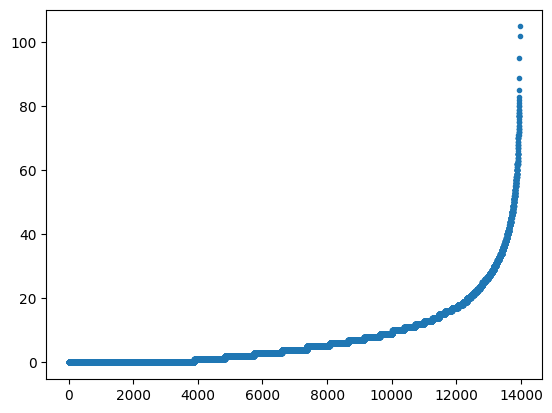

In [297]:
plt.plot(np.sort(np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)), '.')

In [281]:
adata_de.var[np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)!=0].gene_name

ENSG00000000419               DPM1
ENSG00000000457              SCYL3
ENSG00000000460           C1orf112
ENSG00000001461             NIPAL3
ENSG00000001629             ANKIB1
                        ...       
ENSG00000284024            MSANTD7
ENSG00000284194               SCO2
ENSG00000284770               TBCE
ENSG00000288701             PRRC2B
ENSG00000290797    ENSG00000290797
Name: gene_name, Length: 6421, dtype: object

In [227]:
adata_de.var[np.sum(adata_de[(adata_de.obs.target_contrast_gene_name_corrected.isin(genelist))&(adata_de.obs.culture_condition==condition)].layers['adj_p_value']<0.1, axis=0)!=0].gene_name

gene_ids        gene_name
ENSG00000000419  ENSG00000000419             DPM1
ENSG00000000457  ENSG00000000457            SCYL3
ENSG00000000460  ENSG00000000460         C1orf112
ENSG00000000971  ENSG00000000971              CFH
ENSG00000001036  ENSG00000001036            FUCA2
...                          ...              ...
ENSG00000288701  ENSG00000288701           PRRC2B
ENSG00000288722  ENSG00000288722             F8A1
ENSG00000290292  ENSG00000290292            HOMEZ
ENSG00000290797  ENSG00000290797  ENSG00000290797
ENSG00000291237  ENSG00000291237             SOD2

[10067 rows x 2 columns]

In [214]:
cluster = 101
condition = 'Stim48hr'
genelist = adata_final[adata_final.obs.hdbscan==cluster].obs.target_contrast_gene_name_corrected.unique().tolist()
downstream_genelist = []
for gene in genelist:
    adata_final[adata_final.obs.target_contrast_gene_name_corrected..unique().tolist()

In [ ]:
genelist

In [ ]:
df = de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')][['baseMean', 'condition', 'target_name_corrected']]
df = pd.concat([df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')][['baseMean', 'condition', 'target_name_corrected']]])
df = pd.concat([df, de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')][['baseMean', 'condition', 'target_name_corrected']]])
df['zscore'] = df.apply(calculate_expression_zscore, axis=1, df_mean_std=df_mean_std)

In [ ]:


comparison = []
pvalues = []
condition_pair = [('Rest', 'Stim8hr'), ('Rest', 'Stim48hr'), ('Stim8hr', 'Stim48hr')]
for pair in condition_pair:
    pvalues.append(stats.mannwhitneyu(df[df['condition']==pair[0]]['zscore'], df[df['condition']==pair[1]]['zscore'], alternative='greater').pvalue)
    comparison.append(pair[0]+'>'+pair[1])
    pvalues.append(stats.mannwhitneyu(df[df['condition']==pair[0]]['zscore'], df[df['condition']==pair[1]]['zscore'], alternative='less').pvalue)
    comparison.append(pair[0]+'<'+pair[1])

df_comparison = pd.DataFrame({'comparison': comparison, 'pvalue': pvalues})
df_comparison['pvalue'] = df_comparison['pvalue'].apply(lambda x: f"{x:.2e}")